## 특정 스타일 SKU 배분 최적화 시스템
### 사용법: 특정 스타일 코드를 지정하면 해당 스타일의 SKU들을 배분 대상 매장들에게 최적 배분합니다.

## 1. Import Library

In [8]:
import pandas as pd
import numpy as np
from pulp import (
    LpProblem, LpVariable, LpBinary, LpInteger,
    LpMaximize, lpSum, PULP_CBC_CMD, LpContinuous
)

## 2. Import Data

In [12]:
# 1) 데이터 로드
df_sku   = pd.read_csv('../data_real/발주수량.csv')   # columns: PART_CD, COLOR_CD, Size, Quantity
df_store = pd.read_csv('../data_real/매장데이터.csv') # columns: SHOP_ID, QTY_SUM

print("📊 원본 매장 데이터:")
print(df_store.head())
print()

# ===== 🏪 매장 QTY_SUM 기준 내림차순 정렬 =====
df_store = df_store.sort_values('QTY_SUM', ascending=False).reset_index(drop=True)

print("📊 QTY_SUM 기준 정렬된 매장 데이터:")
print(df_store.head())
print(f"   🔝 최대 매장 QTY_SUM: {df_store['QTY_SUM'].iloc[0]:,}개")
print(f"   🔻 최소 매장 QTY_SUM: {df_store['QTY_SUM'].iloc[-1]:,}개")
print(f"   📊 평균 QTY_SUM: {df_store['QTY_SUM'].mean():,.0f}개")
print()

print("📦 전체 SKU 데이터:")
print(df_sku.head())
print()

# ===== 🎯 특정 스타일 선택 =====
# 사용자가 여기서 원하는 스타일 코드를 지정
TARGET_STYLE = "DMDJ85046"  # 🔥 이 부분을 수정하여 원하는 스타일 선택
TARGET_STYLE = "DWLG42044"  # 🔥 이 부분을 수정하여 원하는 스타일 선택

print(f"🎯 선택된 타겟 스타일: {TARGET_STYLE}")

# 선택된 스타일이 실제 데이터에 존재하는지 확인
available_styles = df_sku['PART_CD'].unique().tolist()
print(f"📋 사용 가능한 스타일 목록: {available_styles}")

if TARGET_STYLE not in available_styles:
    print(f"❌ 오류: 지정된 스타일 '{TARGET_STYLE}'이 데이터에 존재하지 않습니다!")
    print(f"💡 다음 중에서 선택하세요: {available_styles}")
    raise ValueError(f"Invalid style: {TARGET_STYLE}")
else:
    print(f"✅ 스타일 '{TARGET_STYLE}' 선택 완료!")

# 선택된 스타일에 해당하는 SKU들만 필터링
df_sku_filtered = df_sku[df_sku['PART_CD'] == TARGET_STYLE].copy()
print(f"\n📦 선택된 스타일의 정보:")
print(f"   SKU 개수: {len(df_sku_filtered)}개")
print(f"   색상 종류: {df_sku_filtered['COLOR_CD'].unique().tolist()}")
print(f"   사이즈 종류: {df_sku_filtered['SIZE_CD'].unique().tolist()}")
print(f"   총 수량: {df_sku_filtered['ORD_QTY'].sum()}개")
print(f"   최소 수량: {df_sku_filtered['ORD_QTY'].min()}개")
print(f"   최대 수량: {df_sku_filtered['ORD_QTY'].max()}개")
print(f"   평균 수량: {df_sku_filtered['ORD_QTY'].mean():.1f}개")
print(f"   평균 수량: {df_sku_filtered['ORD_QTY'].mean():.1f}개")

📊 원본 매장 데이터:
   SHOP_ID SHOP_NM_SHORT  QTY_SUM
0    30040      팩토리이천(직)     7571
1    30025   신세계아울렛시흥(직)     7225
2    10050          롯데본점     6444
3    30019    롯데아울렛김해(직)     5691
4    30041      팩토리죽전(직)     5199

📊 QTY_SUM 기준 정렬된 매장 데이터:
   SHOP_ID SHOP_NM_SHORT  QTY_SUM
0    30040      팩토리이천(직)     7571
1    30025   신세계아울렛시흥(직)     7225
2    10050          롯데본점     6444
3    30019    롯데아울렛김해(직)     5691
4    30041      팩토리죽전(직)     5199
   🔝 최대 매장 QTY_SUM: 7,571개
   🔻 최소 매장 QTY_SUM: 1,138개
   📊 평균 QTY_SUM: 2,321개

📦 전체 SKU 데이터:
     PART_CD COLOR_CD SIZE_CD  ORD_QTY
0  DMDJ85046      BGD      95      230
1  DMDJ85046      BGD     100      400
2  DMDJ85046      BGD     105      270
3  DMDJ85046      BGD     110      100
4  DMDJ85046      BKS      95      360

🎯 선택된 타겟 스타일: DWLG42044
📋 사용 가능한 스타일 목록: ['DMDJ85046', 'DWDJ68046', 'DWDJ8P046', 'DWLG42044', 'DXDJ8C046', 'DXMT33044']
✅ 스타일 'DWLG42044' 선택 완료!

📦 선택된 스타일의 정보:
   SKU 개수: 8개
   색상 종류: ['BKS', 'KAD']
   사이즈 종류: ['XS', 'S', 'M

In [28]:
# ===== 📦 선택된 스타일 데이터로 모든 변수 재정의 =====
# 이제 선택된 스타일의 SKU들만 사용하여 최적화

# SKU 식별자 및 공급량 A_i (선택된 스타일만)
df_sku_filtered['SKU'] = df_sku_filtered['PART_CD'] + '_' + df_sku_filtered['COLOR_CD'] + '_' + df_sku_filtered['SIZE_CD']
A = df_sku_filtered.set_index('SKU')['ORD_QTY'].to_dict()
SKUs = list(A.keys())

# 매장 리스트 및 판매량 합 QTY_SUM (이미 QTY_SUM 기준 내림차순 정렬됨)
stores = df_store['SHOP_ID'].tolist()  # 정렬된 순서대로
QSUM   = df_store.set_index('SHOP_ID')['QTY_SUM'].to_dict()

print(f"🎯 선택된 스타일 '{TARGET_STYLE}' 배분 최적화 준비:")
print(f"   📦 대상 SKU 개수: {len(SKUs)}개")
print(f"   🏪 대상 매장 개수: {len(stores)}개 (QTY_SUM 내림차순 정렬)")
print(f"   📊 총 배분 물량: {sum(A.values())}개")

# ===== 🏆 QTY_SUM 기준 매장 그룹별 배분 제한 시스템 =====
def create_store_allocation_limits(stores, df_store):
    """
    QTY_SUM 기준으로 정렬된 매장들을 그룹별로 나누고 각 SKU당 배분 상한 설정
    
    Args:
        stores: QTY_SUM 기준 내림차순 정렬된 매장 리스트
        df_store: 정렬된 매장 데이터프레임
    
    Returns:
        dict: 각 매장별 SKU당 최대 배분 가능 수량
    """
    
    total_stores = len(stores)
    
    # 그룹별 매장 수 계산
    tier1_count = int(total_stores * 0.3)  # 상위 30%
    tier2_count = int(total_stores * 0.2)  # 그 다음 20%
    tier3_count = total_stores - tier1_count - tier2_count  # 나머지 50%
    
    print(f"\n🏆 매장 그룹별 배분 제한 설정:")
    print(f"   🥇 Tier 1 (상위 30%): {tier1_count}개 매장 → SKU당 최대 3개 배분")
    print(f"   🥈 Tier 2 (다음 20%): {tier2_count}개 매장 → SKU당 최대 2개 배분") 
    print(f"   🥉 Tier 3 (나머지 50%): {tier3_count}개 매장 → SKU당 최대 1개 배분")
    
    # 각 매장별 배분 상한 설정
    store_allocation_limits = {}
    
    for i, store_id in enumerate(stores):
        if i < tier1_count:
            # Tier 1: 상위 30% 매장
            store_allocation_limits[store_id] = 3
            tier = "🥇 Tier 1"
        elif i < tier1_count + tier2_count:
            # Tier 2: 다음 20% 매장  
            store_allocation_limits[store_id] = 2
            tier = "🥈 Tier 2"
        else:
            # Tier 3: 나머지 50% 매장
            store_allocation_limits[store_id] = 1
            tier = "🥉 Tier 3"
    
    # 그룹별 매장 정보 출력 (샘플)
    print(f"\n📊 매장 그룹별 정보 (샘플):")
    for i, store_id in enumerate(stores[:10]):  # 상위 10개 매장만 표시
        limit = store_allocation_limits[store_id]
        qty_sum = QSUM[store_id]
        if i < tier1_count:
            tier = "🥇"
        elif i < tier1_count + tier2_count:
            tier = "🥈"
        else:
            tier = "🥉"
        print(f"   {tier} 매장 {store_id}: QTY_SUM {qty_sum:,}개 → SKU당 최대 {limit}개")
    
    if len(stores) > 10:
        print(f"   ... 외 {len(stores)-10}개 매장")
    
    return store_allocation_limits

# 매장별 배분 상한 생성
store_allocation_limits = create_store_allocation_limits(stores, df_store)

# ===== 🎯 선택된 스타일의 매장 배분 설정 =====
def create_target_style_store_mapping(target_style, stores, df_store):
    """
    선택된 스타일에 대한 배분 가능한 매장을 설정하는 함수
    
    Args:
        target_style: 선택된 스타일 코드
        stores: QTY_SUM 기준 내림차순 정렬된 매장 리스트
        df_store: 정렬된 매장 데이터프레임
    
    Returns:
        list: 선택된 스타일이 배분 가능한 매장 리스트 (정렬 순서 유지)
    """
    
    # === 기본 설정: 모든 매장에 배분 가능 (정렬 순서 유지) ===
    target_stores = stores.copy()
    
    # === 향후 확장 예시 (주석 처리) ===
    # 특정 스타일을 특정 매장에만 배분하도록 설정 가능
    # if target_style == 'DMDJ85046':
    #     # 상위 50개 매장만 선택 (정렬 순서 유지)
    #     target_stores = stores[:50]
    # elif target_style == 'DWDJ68046':
    #     # QTY_SUM > 5000인 매장만 선택 (정렬 순서 유지)
    #     target_stores = [s for s in stores if QSUM[s] > 5000]
    
    return target_stores

# 선택된 스타일의 배분 가능 매장 설정
target_stores = create_target_style_store_mapping(TARGET_STYLE, stores, df_store)

print(f"\n📍 배분 대상 매장:")
print(f"   전체 매장: {len(stores)}개 (QTY_SUM 내림차순 정렬)")
print(f"   선택된 스타일 배분 가능 매장: {len(target_stores)}개")
if len(target_stores) < len(stores):
    excluded_stores = set(stores) - set(target_stores)
    print(f"   제외된 매장: {len(excluded_stores)}개")

# 선택된 스타일의 SKU별 배분 가능 매장 리스트 생성
def get_valid_stores_for_target_sku(sku, target_stores):
    """
    선택된 스타일의 특정 SKU에 대해 배분 가능한 매장 리스트 반환
    
    Args:
        sku: SKU 식별자
        target_stores: 해당 스타일의 배분 가능 매장 리스트 (정렬된 순서)
    
    Returns:
        list: 해당 SKU가 배분 가능한 매장 리스트 (정렬 순서 유지)
    """
    return target_stores  # 현재는 모든 SKU가 동일한 매장에 배분 가능
    
    # 향후 확장 시 SKU별로 다른 매장 제한 가능:
    # if 'XS' in sku or 'XL' in sku:
    #     # 특정 사이즈는 상위 Tier 매장만 (정렬 순서 유지)
    #     return [s for s in target_stores if store_allocation_limits[s] >= 2]
    # else:
    #     return target_stores

# 검증: 선택된 스타일의 각 SKU별 배분 가능 매장 수 확인
print(f"\n🔍 선택된 스타일 SKU별 배분 가능 매장 수:")
for sku in SKUs[:5]:  # 처음 5개만 확인
    valid_stores = get_valid_stores_for_target_sku(sku, target_stores)
    print(f"   📦 {sku}: {len(valid_stores)}개 매장")

print(f"\n✅ 스타일 '{TARGET_STYLE}' 배분 시스템 구축 완료!")
print(f"   🏆 QTY_SUM 기준 매장 그룹별 배분 제한 적용")
print(f"   📊 상위 30% 매장: SKU당 최대 3개")
print(f"   📊 다음 20% 매장: SKU당 최대 2개") 
print(f"   📊 나머지 50% 매장: SKU당 최대 1개")
print(f"   💡 필요시 create_target_style_store_mapping 함수에서 매장 제한 가능")

🎯 선택된 스타일 'DWLG42044' 배분 최적화 준비:
   📦 대상 SKU 개수: 8개
   🏪 대상 매장 개수: 100개 (QTY_SUM 내림차순 정렬)
   📊 총 배분 물량: 1800개

🏆 매장 그룹별 배분 제한 설정:
   🥇 Tier 1 (상위 30%): 30개 매장 → SKU당 최대 3개 배분
   🥈 Tier 2 (다음 20%): 20개 매장 → SKU당 최대 2개 배분
   🥉 Tier 3 (나머지 50%): 50개 매장 → SKU당 최대 1개 배분

📊 매장 그룹별 정보 (샘플):
   🥇 매장 30040: QTY_SUM 7,571개 → SKU당 최대 3개
   🥇 매장 30025: QTY_SUM 7,225개 → SKU당 최대 3개
   🥇 매장 10050: QTY_SUM 6,444개 → SKU당 최대 3개
   🥇 매장 30019: QTY_SUM 5,691개 → SKU당 최대 3개
   🥇 매장 30041: QTY_SUM 5,199개 → SKU당 최대 3개
   🥇 매장 10070: QTY_SUM 5,173개 → SKU당 최대 3개
   🥇 매장 10007: QTY_SUM 5,105개 → SKU당 최대 3개
   🥇 매장 30038: QTY_SUM 4,708개 → SKU당 최대 3개
   🥇 매장 30044: QTY_SUM 4,357개 → SKU당 최대 3개
   🥇 매장 30032: QTY_SUM 4,253개 → SKU당 최대 3개
   ... 외 90개 매장

📍 배분 대상 매장:
   전체 매장: 100개 (QTY_SUM 내림차순 정렬)
   선택된 스타일 배분 가능 매장: 100개

🔍 선택된 스타일 SKU별 배분 가능 매장 수:
   📦 DWLG42044_BKS_XS: 100개 매장
   📦 DWLG42044_BKS_S: 100개 매장
   📦 DWLG42044_BKS_M: 100개 매장
   📦 DWLG42044_BKS_L: 100개 매장
   📦 DWLG42044_KAD_XS: 100개 매장

✅ 스타일 'DWLG42044

In [29]:
# ===== 📊 선택된 스타일의 희소/충분 SKU 분류 =====
# 선택된 스타일 내에서만 희소/충분 SKU 분류 수행

num_target_stores = len(target_stores)  # 배분 대상 매장 수
print(f"🎯 희소/충분 SKU 분류 기준:")
print(f"   배분 대상 매장 수: {num_target_stores}개")
print(f"   희소 SKU 기준: 수량 < {num_target_stores}개 (매장 수보다 적음)")

# 기본 희소 SKU 식별 (선택된 스타일 내에서)
basic_scarce = [sku for sku, qty in A.items() if qty < num_target_stores]

print(f"\n📊 선택된 스타일 '{TARGET_STYLE}'의 SKU 분류:")
print(f"   총 SKU 개수: {len(SKUs)}개")
print(f"   기본 희소 SKU: {len(basic_scarce)}개")

# 확장된 희소 SKU 그룹 생성 (동일 스타일 내에서 연관 SKU 추가)
extended_scarce = set(basic_scarce)

for scarce_sku in basic_scarce:
    # 해당 SKU의 색상, 사이즈 추출 (이미 선택된 스타일이므로 스타일은 동일)
    color = df_sku_filtered.loc[df_sku_filtered['SKU']==scarce_sku, 'COLOR_CD'].iloc[0]
    size = df_sku_filtered.loc[df_sku_filtered['SKU']==scarce_sku, 'SIZE_CD'].iloc[0]
    
    # 동일 스타일에서 관련 SKU들 찾기 (이미 필터링된 데이터 사용)
    for related_sku in SKUs:
        if related_sku != scarce_sku:  # 자기 자신 제외
            related_color = df_sku_filtered.loc[df_sku_filtered['SKU']==related_sku, 'COLOR_CD'].iloc[0]
            related_size = df_sku_filtered.loc[df_sku_filtered['SKU']==related_sku, 'SIZE_CD'].iloc[0]
            
            # 같은 색상 다른 사이즈 OR 같은 사이즈 다른 색상
            if (color == related_color and size != related_size) or \
               (color != related_color and size == related_size):
                extended_scarce.add(related_sku)

scarce = list(extended_scarce)
abundant = [sku for sku in SKUs if sku not in scarce]

print(f"   확장된 희소 SKU: {len(scarce)}개")
print(f"   충분 SKU: {len(abundant)}개")

print(f"\n📋 희소 SKU 목록:")
for sku in scarce:
    qty = A[sku]
    color = df_sku_filtered.loc[df_sku_filtered['SKU']==sku, 'COLOR_CD'].iloc[0]
    size = df_sku_filtered.loc[df_sku_filtered['SKU']==sku, 'SIZE_CD'].iloc[0]
    print(f"   📦 {sku}: {qty}개 (색상:{color}, 사이즈:{size})")

print(f"\n📋 충분 SKU 목록 (일부):")
for sku in abundant[:5]:  # 처음 5개만 표시
    qty = A[sku]
    color = df_sku_filtered.loc[df_sku_filtered['SKU']==sku, 'COLOR_CD'].iloc[0]
    size = df_sku_filtered.loc[df_sku_filtered['SKU']==sku, 'SIZE_CD'].iloc[0]
    print(f"   📦 {sku}: {qty}개 (색상:{color}, 사이즈:{size})")

if len(abundant) > 5:
    print(f"   + 추가 {len(abundant)-5}개 SKU...")

print(f"\n✅ 선택된 스타일 '{TARGET_STYLE}'의 SKU 분류 완료!")
print(f"   🔴 희소 SKU: {len(scarce)}개 (전략적 배치 필요)")
print(f"   🟢 충분 SKU: {len(abundant)}개 (수요 기반 배치)")

🎯 희소/충분 SKU 분류 기준:
   배분 대상 매장 수: 100개
   희소 SKU 기준: 수량 < 100개 (매장 수보다 적음)

📊 선택된 스타일 'DWLG42044'의 SKU 분류:
   총 SKU 개수: 8개
   기본 희소 SKU: 2개
   확장된 희소 SKU: 8개
   충분 SKU: 0개

📋 희소 SKU 목록:
   📦 DWLG42044_KAD_XS: 60개 (색상:KAD, 사이즈:XS)
   📦 DWLG42044_BKS_XS: 70개 (색상:BKS, 사이즈:XS)
   📦 DWLG42044_KAD_L: 200개 (색상:KAD, 사이즈:L)
   📦 DWLG42044_KAD_S: 180개 (색상:KAD, 사이즈:S)
   📦 DWLG42044_BKS_S: 190개 (색상:BKS, 사이즈:S)
   📦 DWLG42044_BKS_M: 440개 (색상:BKS, 사이즈:M)
   📦 DWLG42044_KAD_M: 360개 (색상:KAD, 사이즈:M)
   📦 DWLG42044_BKS_L: 300개 (색상:BKS, 사이즈:L)

📋 충분 SKU 목록 (일부):

✅ 선택된 스타일 'DWLG42044'의 SKU 분류 완료!
   🔴 희소 SKU: 8개 (전략적 배치 필요)
   🟢 충분 SKU: 0개 (수요 기반 배치)


In [15]:
# ===== 📊 선택된 스타일의 색상·사이즈 그룹 생성 =====
# 선택된 스타일에만 집중하여 색상·사이즈 그룹 생성

# 선택된 스타일만 처리 (단일 스타일)
styles = [TARGET_STYLE]  # 선택된 스타일만 포함
I_s = {TARGET_STYLE: SKUs}  # 선택된 스타일의 모든 SKU
K_s = {TARGET_STYLE: df_sku_filtered['COLOR_CD'].unique().tolist()}  # 색상 리스트
L_s = {TARGET_STYLE: df_sku_filtered['SIZE_CD'].unique().tolist()}   # 사이즈 리스트

print(f"🎯 선택된 스타일 '{TARGET_STYLE}'의 그룹 정보:")
print(f"   📦 SKU 개수: {len(I_s[TARGET_STYLE])}개")
print(f"   🎨 색상 종류: {len(K_s[TARGET_STYLE])}개 - {K_s[TARGET_STYLE]}")  
print(f"   📏 사이즈 종류: {len(L_s[TARGET_STYLE])}개 - {L_s[TARGET_STYLE]}")

# 색상별 SKU 분포 확인
print(f"\n📈 색상별 SKU 분포:")
for color in K_s[TARGET_STYLE]:
    color_skus = [sku for sku in SKUs if df_sku_filtered.loc[df_sku_filtered['SKU']==sku, 'COLOR_CD'].iloc[0] == color]
    color_qty = sum(A[sku] for sku in color_skus)
    print(f"   🎨 {color}: {len(color_skus)}개 SKU, 총 {color_qty}개 수량")

# 사이즈별 SKU 분포 확인  
print(f"\n📏 사이즈별 SKU 분포:")
for size in L_s[TARGET_STYLE]:
    size_skus = [sku for sku in SKUs if df_sku_filtered.loc[df_sku_filtered['SKU']==sku, 'SIZE_CD'].iloc[0] == size]
    size_qty = sum(A[sku] for sku in size_skus)
    print(f"   📏 {size}: {len(size_skus)}개 SKU, 총 {size_qty}개 수량")

print(f"\n✅ 선택된 스타일 '{TARGET_STYLE}'의 그룹 생성 완료!")
print(f"   🎨 색상 다양성: {len(K_s[TARGET_STYLE])}종류")
print(f"   📏 사이즈 다양성: {len(L_s[TARGET_STYLE])}종류")
print(f"   📦 총 SKU 조합: {len(I_s[TARGET_STYLE])}개")

🎯 선택된 스타일 'DWLG42044'의 그룹 정보:
   📦 SKU 개수: 8개
   🎨 색상 종류: 2개 - ['BKS', 'KAD']
   📏 사이즈 종류: 4개 - ['XS', 'S', 'M', 'L']

📈 색상별 SKU 분포:
   🎨 BKS: 4개 SKU, 총 1000개 수량
   🎨 KAD: 4개 SKU, 총 800개 수량

📏 사이즈별 SKU 분포:
   📏 XS: 2개 SKU, 총 130개 수량
   📏 S: 2개 SKU, 총 370개 수량
   📏 M: 2개 SKU, 총 800개 수량
   📏 L: 2개 SKU, 총 500개 수량

✅ 선택된 스타일 'DWLG42044'의 그룹 생성 완료!
   🎨 색상 다양성: 2종류
   📏 사이즈 다양성: 4종류
   📦 총 SKU 조합: 8개


In [ ]:
# ===== 🔧 누락된 함수들과 변수들 정의 =====

# 1) 단일 스타일용 SKU-매장 유효성 검사 함수
def get_valid_stores_for_sku(sku, df_sku_filtered, stores):
    """
    특정 SKU에 대해 배분 가능한 매장 리스트 반환
    단일 스타일 최적화에서는 모든 매장이 배분 가능
    """
    return target_stores  # 선택된 스타일의 배분 가능 매장들

# 2) 실험 시나리오 파라미터 정의
EXPERIMENT_SCENARIOS = {
    "baseline": {
        "description": "기본 시나리오: 수요 기반 분배, 최소한의 커버리지/균형 제약",
        "coverage_weight": 0.1,
        "balance_penalty": 0.01,
        "allocation_penalty": 0.01,
        "allocation_range_min": 0.5,
        "allocation_range_max": 1.5,
        "min_coverage_threshold": 0.0
    },
    
    "coverage_focused": {
        "description": "커버리지 중심: 매장별 상품 다양성 극대화",
        "coverage_weight": 2.0,
        "balance_penalty": 0.05,
        "allocation_penalty": 0.01,
        "allocation_range_min": 0.3,
        "allocation_range_max": 2.0,
        "min_coverage_threshold": 0.3
    },
    
    "balance_focused": {
        "description": "균형 중심: 색상-사이즈 균형 및 매장별 공평 분배",
        "coverage_weight": 0.5,
        "balance_penalty": 1.0,
        "allocation_penalty": 0.5,
        "allocation_range_min": 0.8,
        "allocation_range_max": 1.2,
        "min_coverage_threshold": 0.1
    },
    
    "hybrid": {
        "description": "하이브리드: 커버리지와 균형의 적절한 조합",
        "coverage_weight": 1.0,
        "balance_penalty": 0.3,
        "allocation_penalty": 0.2,
        "allocation_range_min": 0.6,
        "allocation_range_max": 1.4,
        "min_coverage_threshold": 0.2
    },
    
    "extreme_coverage": {
        "description": "극단적 커버리지: 최대한 많은 다양성 확보 (실현성 낮을 수 있음)",
        "coverage_weight": 5.0,
        "balance_penalty": 0.1,
        "allocation_penalty": 0.05,
        "allocation_range_min": 0.2,
        "allocation_range_max": 3.0,
        "min_coverage_threshold": 0.5
    }
}

# 3) 현재 실험 시나리오 선택
CURRENT_SCENARIO = "baseline"  # 여기를 변경하여 다른 시나리오 테스트

# 4) 선택된 시나리오의 파라미터 로드
params = EXPERIMENT_SCENARIOS[CURRENT_SCENARIO]

# 5) 단일 스타일용 매장 매핑 생성
style_store_mapping = {TARGET_STYLE: target_stores}

print(f"🔧 누락된 변수들 정의 완료!")
print(f"   🎯 선택된 시나리오: {CURRENT_SCENARIO}")
print(f"   📋 설명: {params['description']}")
print(f"   🏪 스타일-매장 매핑: {TARGET_STYLE} → {len(target_stores)}개 매장")

print(f"\n📊 시나리오 파라미터:")
for key, value in params.items():
    if key != 'description':
        print(f"   {key}: {value}")


## Step 1: Coverage MILP

In [30]:
# ===== STEP1: 선택된 스타일의 Coverage MILP (희소 SKU 커버리지 최적화) =====
# 목적: 선택된 스타일의 희소 SKU들을 전략적으로 배치하여 각 매장이 
#       해당 스타일의 다양한 색상과 사이즈를 커버할 수 있도록 최적화

prob1 = LpProblem(f'Step1_Coverage_{TARGET_STYLE}', LpMaximize)

print(f"🎯 Step1: 스타일 '{TARGET_STYLE}'의 Coverage 최적화 시작")
print(f"   🔴 희소 SKU: {len(scarce)}개")
print(f"   🏪 대상 매장: {len(target_stores)}개")

# ===== 변수 정의 =====
# b[i][j]: 희소 SKU i를 매장 j에 할당할지 여부 (0 또는 1)
#          예: b['DMDJ85046_BGD_95'][30040] = 1 이면 
#              DMDJ85046 스타일의 BGD 색상 95 사이즈를 매장 30040에 할당
b = {}
for i in scarce:
    valid_stores_for_sku = get_valid_stores_for_target_sku(i, target_stores)
    b[i] = {}
    for j in stores:
        if j in valid_stores_for_sku:
            # 해당 SKU가 이 매장에 배분 가능한 경우만 변수 생성
            b[i][j] = LpVariable(f'b_{i}_{j}', cat=LpBinary)
        else:
            # 배분 불가능한 매장에는 0으로 고정 (변수 생성 안함)
            b[i][j] = 0

# color_coverage[s,j]: 매장 j가 스타일 s의 색상을 몇 개 커버하는지
# 선택된 스타일에만 집중
color_coverage = {}
s = TARGET_STYLE  # 선택된 스타일만 처리
for j in stores:
    if j in target_stores:
        color_coverage[(s,j)] = LpVariable(f"color_coverage_{s}_{j}", lowBound=0, upBound=len(K_s[s]), cat=LpInteger)
    else:
        color_coverage[(s,j)] = 0  # 해당 매장은 이 스타일 커버 불가

# size_coverage[s,j]: 매장 j가 스타일 s의 사이즈를 몇 개 커버하는지
# 선택된 스타일에만 집중
size_coverage = {}
for j in stores:
    if j in target_stores:
        size_coverage[(s,j)] = LpVariable(f"size_coverage_{s}_{j}", lowBound=0, upBound=len(L_s[s]), cat=LpInteger)
    else:
        size_coverage[(s,j)] = 0  # 해당 매장은 이 스타일 커버 불가

print(f"   📊 변수 개수:")
print(f"      할당 변수: {sum(1 for i in scarce for j in stores if isinstance(b[i][j], LpVariable))}개")
print(f"      색상 커버리지 변수: {sum(1 for j in stores if isinstance(color_coverage[(s,j)], LpVariable))}개")
print(f"      사이즈 커버리지 변수: {sum(1 for j in stores if isinstance(size_coverage[(s,j)], LpVariable))}개")

# ===== 목적함수 =====
# 선택된 스타일의 커버리지 최대화: 색상 커버리지 + 사이즈 커버리지 + 할당 보너스
epsilon = 0.001  # 타이브레이커: 동일한 커버리지면 더 많은 할당을 선호

# 색상 커버리지 합계 (선택된 스타일, 유효한 매장만)
color_coverage_sum = lpSum(
    color_coverage[(s,j)] for j in stores 
    if isinstance(color_coverage[(s,j)], LpVariable)
)

# 사이즈 커버리지 합계 (선택된 스타일, 유효한 매장만)
size_coverage_sum = lpSum(
    size_coverage[(s,j)] for j in stores 
    if isinstance(size_coverage[(s,j)], LpVariable)
)

# 할당량 보너스 (유효한 SKU-매장 조합만)
allocation_bonus = epsilon * lpSum(
    b[i][j] for i in scarce for j in stores 
    if isinstance(b[i][j], LpVariable)
)

prob1 += color_coverage_sum + size_coverage_sum + allocation_bonus

print(f"   🎯 목적함수: 색상 커버리지 + 사이즈 커버리지 + {epsilon} × 할당량")

# ===== 제약조건 =====

# 1) 희소 SKU 공급량 제한
# 각 희소 SKU의 총 할당량은 공급 가능한 수량을 초과할 수 없음
for i in scarce:
    valid_allocation_sum = lpSum(
        b[i][j] for j in stores 
        if isinstance(b[i][j], LpVariable)
    )
    prob1 += valid_allocation_sum <= A[i]

print(f"   ✅ 제약조건 1: 희소 SKU 공급량 제한 ({len(scarce)}개 제약)")

# 1-1) 매장별 SKU 배분 상한 제한 (QTY_SUM 기준 그룹별)
# 각 매장에서 각 희소 SKU는 해당 매장의 tier에 따른 상한을 넘을 수 없음
# Step1에서는 binary variable이므로 실제로는 0 또는 1개만 할당
tier_constraint_count = 0
for j in stores:
    if j in target_stores:
        max_allocation = store_allocation_limits[j]
        # 해당 매장에서 할당받는 희소 SKU의 총 개수는 tier 제한을 넘을 수 없음
        store_scarce_allocation = lpSum(
            b[i][j] for i in scarce 
            if isinstance(b[i][j], LpVariable)
        )
        prob1 += store_scarce_allocation <= max_allocation
        tier_constraint_count += 1

print(f"   ✅ 제약조건 1-1: 매장별 희소 SKU 배분 상한 제한 ({tier_constraint_count}개 제약)")
print(f"      🥇 Tier 1 매장: 최대 3개 희소 SKU")
print(f"      🥈 Tier 2 매장: 최대 2개 희소 SKU") 
print(f"      🥉 Tier 3 매장: 최대 1개 희소 SKU")

# 2) 색상 커버리지 개수 제약조건 - 직접 연결
# 매장 j가 선택된 스타일에서 커버하는 색상 개수는 실제 할당받은 색상 종류 수와 같아야 함
s = TARGET_STYLE
for j in stores:
    # 해당 매장이 이 스타일에 대해 유효한지 확인
    if j not in target_stores:
        continue  # 유효하지 않은 매장-스타일 조합은 스킵
        
    # color_coverage가 변수인 경우만 제약조건 추가
    if not isinstance(color_coverage[(s,j)], LpVariable):
        continue
        
    # 각 색상별로 이진 변수 생성 (해당 색상을 커버하는지)
    color_covered = {}
    for k in K_s[s]:
        color_covered[k] = LpVariable(f"color_covered_{s}_{k}_{j}", cat=LpBinary)
        
        # 해당 색상의 희소 SKU들 (유효한 매장-SKU 조합만)
        idx_color = [i for i in I_s[s] 
                    if df_sku_filtered.loc[df_sku_filtered['SKU']==i,'COLOR_CD'].iloc[0]==k 
                    and i in scarce
                    and isinstance(b[i][j], LpVariable)]
        
        if idx_color:
            # 해당 색상의 SKU를 하나라도 받으면 색상 커버됨
            prob1 += lpSum(b[i][j] for i in idx_color) >= color_covered[k]
            # 색상이 커버되지 않으면 해당 색상 SKU 할당 불가
            for i in idx_color:
                prob1 += b[i][j] <= color_covered[k]
        else:
            # 희소 SKU가 없는 색상은 커버 불가
            prob1 += color_covered[k] == 0
    
    # 커버리지 개수 = 커버된 색상들의 합
    prob1 += color_coverage[(s,j)] == lpSum(color_covered[k] for k in K_s[s])

print(f"   ✅ 제약조건 2: 색상 커버리지 제약 ({len([j for j in target_stores])}개 매장)")

# 3) 사이즈 커버리지 개수 제약조건 - 직접 연결
for j in stores:
    # 해당 매장이 이 스타일에 대해 유효한지 확인
    if j not in target_stores:
        continue  # 유효하지 않은 매장-스타일 조합은 스킵
        
    # size_coverage가 변수인 경우만 제약조건 추가
    if not isinstance(size_coverage[(s,j)], LpVariable):
        continue
        
    # 각 사이즈별로 이진 변수 생성 (해당 사이즈를 커버하는지)
    size_covered = {}
    for l in L_s[s]:
        size_covered[l] = LpVariable(f"size_covered_{s}_{l}_{j}", cat=LpBinary)
        
        # 해당 사이즈의 희소 SKU들 (유효한 매장-SKU 조합만)
        idx_size = [i for i in I_s[s] 
                   if df_sku_filtered.loc[df_sku_filtered['SKU']==i,'SIZE_CD'].iloc[0]==l 
                   and i in scarce
                   and isinstance(b[i][j], LpVariable)]
        
        if idx_size:
            # 해당 사이즈의 SKU를 하나라도 받으면 사이즈 커버됨
            prob1 += lpSum(b[i][j] for i in idx_size) >= size_covered[l]
            # 사이즈가 커버되지 않으면 해당 사이즈 SKU 할당 불가
            for i in idx_size:
                prob1 += b[i][j] <= size_covered[l]
        else:
            # 희소 SKU가 없는 사이즈는 커버 불가
            prob1 += size_covered[l] == 0
    
    # 커버리지 개수 = 커버된 사이즈들의 합
    prob1 += size_coverage[(s,j)] == lpSum(size_covered[l] for l in L_s[s])

print(f"   ✅ 제약조건 3: 사이즈 커버리지 제약 ({len([j for j in target_stores])}개 매장)")

# 4) 최적화 문제 해결
print(f"\n🚀 Step1 Coverage 최적화 실행...")
print(f"   🎯 스타일: {TARGET_STYLE}")
print(f"   🔴 희소 SKU: {len(scarce)}개")
print(f"   🏪 대상 매장: {len(target_stores)}개")

prob1.solve(PULP_CBC_CMD(msg=False))

# 5) 1단계 결과 저장
# b_hat[i,j]: 희소 SKU i가 매장 j에 할당되었는지 여부 (0 또는 1)
# 이 결과는 Step2에서 최소 할당량 보장 제약조건으로 사용됨
b_hat = {}
for i in scarce:
    for j in stores:
        if isinstance(b[i][j], LpVariable):
            # 변수인 경우: 최적화 결과값 저장
            b_hat[(i,j)] = int(b[i][j].value()) if b[i][j].value() is not None else 0
        else:
            # 변수가 아닌 경우: 0으로 설정 (배분 불가능한 매장-SKU 조합)
            b_hat[(i,j)] = 0

if prob1.status == 1:
    print("✅ Step1 Coverage 최적화 완료!")
    
    # 결과 요약
    total_allocated = sum(b_hat.values())
    covered_stores = len([j for j in target_stores if sum(b_hat[(i,j)] for i in scarce) > 0])
    
    print(f"\n📊 Step1 결과 요약:")
    print(f"   🎯 할당된 희소 SKU: {total_allocated}개")
    print(f"   🏪 희소 SKU를 받은 매장: {covered_stores}개 / {len(target_stores)}개")
    print(f"   📈 커버리지 비율: {covered_stores/len(target_stores)*100:.1f}%")
    
else:
    print(f"❌ Step1 Coverage 최적화 실패: 상태 {prob1.status}")
    print("   💡 제약조건이나 데이터를 확인해주세요.")

🎯 Step1: 스타일 'DWLG42044'의 Coverage 최적화 시작
   🔴 희소 SKU: 8개
   🏪 대상 매장: 100개
   📊 변수 개수:
      할당 변수: 800개
      색상 커버리지 변수: 100개
      사이즈 커버리지 변수: 100개
   🎯 목적함수: 색상 커버리지 + 사이즈 커버리지 + 0.001 × 할당량
   ✅ 제약조건 1: 희소 SKU 공급량 제한 (8개 제약)
   ✅ 제약조건 1-1: 매장별 희소 SKU 배분 상한 제한 (100개 제약)
      🥇 Tier 1 매장: 최대 3개 희소 SKU
      🥈 Tier 2 매장: 최대 2개 희소 SKU
      🥉 Tier 3 매장: 최대 1개 희소 SKU
   ✅ 제약조건 2: 색상 커버리지 제약 (100개 매장)
   ✅ 제약조건 3: 사이즈 커버리지 제약 (100개 매장)

🚀 Step1 Coverage 최적화 실행...
   🎯 스타일: DWLG42044
   🔴 희소 SKU: 8개
   🏪 대상 매장: 100개
✅ Step1 Coverage 최적화 완료!

📊 Step1 결과 요약:
   🎯 할당된 희소 SKU: 180개
   🏪 희소 SKU를 받은 매장: 100개 / 100개
   📈 커버리지 비율: 100.0%


## Step 2: Quantity ILP

In [31]:
# ===== 📁 실험 결과 저장 관리 시스템 =====

import os
from datetime import datetime

def create_experiment_output_path(scenario_name):
    """실험별 고유한 출력 폴더 및 파일명 생성"""
    
    # 현재 시간 (YYYYMMDD_HHMMSS 형식)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 실험 폴더명: 시나리오_날짜시간
    experiment_folder = f"{scenario_name}_{timestamp}"
    
    # 전체 경로
    output_base_path = "../output"
    experiment_path = os.path.join(output_base_path, experiment_folder)
    
    # 폴더 생성 (존재하지 않으면)
    os.makedirs(experiment_path, exist_ok=True)
    
    # 파일명 패턴 생성
    file_prefix = f"{scenario_name}_{timestamp}"
    
    file_paths = {
        'allocation_results': os.path.join(experiment_path, f"{file_prefix}_allocation_results.csv"),
        'store_summary': os.path.join(experiment_path, f"{file_prefix}_store_summary.csv"),
        'style_analysis': os.path.join(experiment_path, f"{file_prefix}_style_analysis.csv"),
        'top_performers': os.path.join(experiment_path, f"{file_prefix}_top_performers.csv"),
        'scarce_effectiveness': os.path.join(experiment_path, f"{file_prefix}_scarce_effectiveness.csv"),
        'experiment_params': os.path.join(experiment_path, f"{file_prefix}_experiment_params.json"),
        'experiment_summary': os.path.join(experiment_path, f"{file_prefix}_experiment_summary.txt")
    }
    
    return experiment_path, file_paths

def save_experiment_metadata(file_paths, scenario_name, params, optimization_result):
    """실험 메타데이터 저장"""
    import json
    
    # 1. 실험 파라미터 JSON 저장
    experiment_info = {
        'scenario_name': scenario_name,
        'timestamp': datetime.now().isoformat(),
        'parameters': params,
        'optimization_status': optimization_result.get('status', 'unknown'),
        'objective_value': optimization_result.get('objective_value', None)
    }
    
    with open(file_paths['experiment_params'], 'w', encoding='utf-8') as f:
        json.dump(experiment_info, f, indent=2, ensure_ascii=False)
    
    # 2. 실험 요약 텍스트 저장
    summary_text = f"""
========================================
실험 결과 요약
========================================

실험 시나리오: {scenario_name}
실험 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
설명: {params.get('description', 'N/A')}

📊 실험 파라미터:
- 커버리지 가중치: {params['coverage_weight']}
- 균형 페널티: {params['balance_penalty']}
- 배분 페널티: {params['allocation_penalty']}
- 배분 범위: {params['allocation_range_min']*100:.0f}% ~ {params['allocation_range_max']*100:.0f}%
- 최소 커버리지: {params['min_coverage_threshold']*100:.0f}%

⚡ 최적화 결과:
- 상태: {optimization_result.get('status', 'unknown')}
- 목적함수 값: {optimization_result.get('objective_value', 'N/A')}

📁 생성된 파일들:
- 할당 결과: {os.path.basename(file_paths['allocation_results'])}
- 매장 요약: {os.path.basename(file_paths['store_summary'])}
- 스타일 분석: {os.path.basename(file_paths['style_analysis'])}
- 최고 성과자: {os.path.basename(file_paths['top_performers'])}
- 희소 SKU 효과: {os.path.basename(file_paths['scarce_effectiveness'])}

========================================
"""
    
    with open(file_paths['experiment_summary'], 'w', encoding='utf-8') as f:
        f.write(summary_text)
    
    print(f"📁 실험 메타데이터 저장 완료:")
    print(f"   📋 파라미터: {file_paths['experiment_params']}")
    print(f"   📄 요약: {file_paths['experiment_summary']}")

print("📁 실험 결과 저장 관리 시스템 준비 완료!")
print("   💡 실제 출력 경로는 시나리오 설정 후 생성됩니다.")


📁 실험 결과 저장 관리 시스템 준비 완료!
   💡 실제 출력 경로는 시나리오 설정 후 생성됩니다.


In [32]:
# ===== 🔬 실험 설계: 파라미터 설정 =====

# 실험 시나리오 정의
EXPERIMENT_SCENARIOS = {
    "baseline": {
        "description": "기본 시나리오: 수요 기반 분배, 최소한의 커버리지/균형 제약",
        "coverage_weight": 0.1,
        "balance_penalty": 0.01,
        "allocation_penalty": 0.01,
        "allocation_range_min": 0.5,
        "allocation_range_max": 1.5,
        "min_coverage_threshold": 0.0
    },
    
    "coverage_focused": {
        "description": "커버리지 중심: 매장별 상품 다양성 극대화",
        "coverage_weight": 2.0,
        "balance_penalty": 0.05,
        "allocation_penalty": 0.01,
        "allocation_range_min": 0.3,
        "allocation_range_max": 2.0,
        "min_coverage_threshold": 0.3
    },
    
    "balance_focused": {
        "description": "균형 중심: 색상-사이즈 균형 및 매장별 공평 분배",
        "coverage_weight": 0.5,
        "balance_penalty": 1.0,
        "allocation_penalty": 0.5,
        "allocation_range_min": 0.8,
        "allocation_range_max": 1.2,
        "min_coverage_threshold": 0.1
    },
    
    "hybrid": {
        "description": "하이브리드: 커버리지와 균형의 적절한 조합",
        "coverage_weight": 1.0,
        "balance_penalty": 0.3,
        "allocation_penalty": 0.2,
        "allocation_range_min": 0.6,
        "allocation_range_max": 1.4,
        "min_coverage_threshold": 0.2
    },
    
    "extreme_coverage": {
        "description": "극단적 커버리지: 최대한 많은 다양성 확보 (실현성 낮을 수 있음)",
        "coverage_weight": 5.0,
        "balance_penalty": 0.1,
        "allocation_penalty": 0.05,
        "allocation_range_min": 0.2,
        "allocation_range_max": 3.0,
        "min_coverage_threshold": 0.5
    }
}

# 🎯 현재 실험 시나리오 선택
CURRENT_SCENARIO = "baseline"  # 여기를 변경하여 다른 시나리오 테스트

print(f"🔬 현재 선택된 시나리오: {CURRENT_SCENARIO}")
print(f"📋 설명: {EXPERIMENT_SCENARIOS[CURRENT_SCENARIO]['description']}")

# 선택된 시나리오의 파라미터 로드
params = EXPERIMENT_SCENARIOS[CURRENT_SCENARIO]

print(f"\n📊 선택된 시나리오의 파라미터:")
for key, value in params.items():
    if key != 'description':
        print(f"   {key}: {value}")

# ===== 🎯 단일 스타일용 매장 매핑 생성 =====
# 단일 스타일이므로 모든 매장이 해당 스타일에 배분 가능
style_store_mapping = {TARGET_STYLE: target_stores}

print(f"\n✅ 시나리오 설정 완료!")
print(f"   🎯 스타일: {TARGET_STYLE}")
print(f"   🏪 배분 가능 매장: {len(target_stores)}개")
print(f"   📊 실험 파라미터: {CURRENT_SCENARIO} 시나리오 적용")
    # 베이스라인: 기본 가중치 기반 분배 (기존 방식과 유사)
    "baseline": {
        "coverage_weight": 0.0,           # 커버리지 보너스 가중치
        "balance_penalty": 0.0,           # 커버리지 불균형 페널티
        "allocation_penalty": 0.0,        # 배분 불균형 페널티
        "allocation_range_min": 0.3,      # 배분량 최소 비율 (30%)
        "allocation_range_max": 3.0,      # 배분량 최대 비율 (300%)
        "min_coverage_threshold": 0.0,    # 최소 커버리지 임계값 (비활성화)
        "step1_epsilon": 0.001,           # Step1 타이브레이커
        "description": "기본 수요 기반 분배 (커버리지 고려 안함)"
    },
    
    # 커버리지 중심: 매장별 다양성 최대화
    "coverage_focused": {
        "coverage_weight": 1.0,           # 커버리지 보너스 강화
        "balance_penalty": 0.1,           # 적당한 균형 페널티
        "allocation_penalty": 0.01,       # 약한 배분 페널티
        "allocation_range_min": 0.3,      
        "allocation_range_max": 3.0,      
        "min_coverage_threshold": 0.1,    # 최소 10% 커버리지
        "step1_epsilon": 0.001,
        "description": "매장별 상품 다양성 최대화"
    },
    
    # 균형 중심: 색상-사이즈 균형 + 매장별 공정 분배
    "balance_focused": {
        "coverage_weight": 0.1,           # 적당한 커버리지 보너스
        "balance_penalty": 0.5,           # 강한 균형 페널티
        "allocation_penalty": 2.0,        # 강한 배분 페널티
        "allocation_range_min": 0.7,      # 좁은 배분 범위 (70%-130%)
        "allocation_range_max": 1.3,      
        "min_coverage_threshold": 0.05,   # 최소 5% 커버리지
        "step1_epsilon": 0.001,
        "description": "색상-사이즈 균형 + 공정한 매장별 분배"
    },
    
    # 하이브리드: 적절한 트레이드오프
    "hybrid": {
        "coverage_weight": 0.3,           # 중간 수준 커버리지
        "balance_penalty": 0.1,           # 중간 수준 균형
        "allocation_penalty": 0.5,        # 중간 수준 배분 제어
        "allocation_range_min": 0.5,      # 중간 수준 범위 (50%-150%)
        "allocation_range_max": 1.5,      
        "min_coverage_threshold": 0.05,   # 최소 5% 커버리지
        "step1_epsilon": 0.001,
        "description": "커버리지와 균형의 적절한 트레이드오프"
    },
    
    # 극단적 커버리지: 완벽한 다양성 추구
    "extreme_coverage": {
        "coverage_weight": 5.0,           # 매우 강한 커버리지 보너스
        "balance_penalty": 1.0,           # 강한 균형 페널티
        "allocation_penalty": 0.1,        # 약한 배분 페널티
        "allocation_range_min": 0.2,      # 넓은 배분 범위
        "allocation_range_max": 5.0,      
        "min_coverage_threshold": 0.2,    # 최소 20% 커버리지
        "step1_epsilon": 0.001,
        "description": "최대한 많은 매장에서 최대한 다양한 상품 확보"
    }
}

# ===== 🎯 선택된 스타일 전용 시나리오 설정 =====
# 현재 실험할 시나리오 선택 (스타일별로 개별 최적화)
# BASE_SCENARIO = "baseline"    # 기본 시나리오 선택
# BASE_SCENARIO = "coverage_focused"
# BASE_SCENARIO = "balance_focused"
# BASE_SCENARIO = "hybrid"
BASE_SCENARIO = "extreme_coverage"

# 선택된 스타일을 포함한 시나리오 이름 생성
CURRENT_SCENARIO = f"{BASE_SCENARIO}_{TARGET_STYLE}"

# 선택된 시나리오의 파라미터 로드
params = EXPERIMENT_SCENARIOS[BASE_SCENARIO].copy()
params['target_style'] = TARGET_STYLE  # 선택된 스타일 정보 추가
params['description'] = f"{params['description']} (스타일: {TARGET_STYLE})"

print(f"🎯 선택된 스타일 전용 실험 설정:")
print(f"   📦 대상 스타일: {TARGET_STYLE}")
print(f"   🔬 베이스 시나리오: {BASE_SCENARIO}")
print(f"   📝 최종 시나리오명: {CURRENT_SCENARIO}")
print(f"   📋 설명: {params['description']}")
print(f"   ⚙️  주요 파라미터:")
print(f"      - 커버리지 가중치: {params['coverage_weight']}")
print(f"      - 균형 페널티: {params['balance_penalty']}")
print(f"      - 배분 페널티: {params['allocation_penalty']}")
print(f"      - 배분 범위: {params['allocation_range_min']*100:.0f}%-{params['allocation_range_max']*100:.0f}%")

# 현재 실험의 출력 경로 생성 (시나리오 설정 완료 후)
experiment_output_path, experiment_file_paths = create_experiment_output_path(CURRENT_SCENARIO)

print(f"\n📁 실험 출력 경로 설정 완료:")
print(f"   🗂️  폴더: {experiment_output_path}")
print(f"   📝 시나리오: {CURRENT_SCENARIO}")
print(f"   🕐 타임스탬프: {datetime.now().strftime('%Y%m%d_%H%M%S')}")
print(f"   📄 생성될 파일 수: {len(experiment_file_paths)}개")


🎯 선택된 스타일 전용 실험 설정:
   📦 대상 스타일: DWLG42044
   🔬 베이스 시나리오: extreme_coverage
   📝 최종 시나리오명: extreme_coverage_DWLG42044
   📋 설명: 최대한 많은 매장에서 최대한 다양한 상품 확보 (스타일: DWLG42044)
   ⚙️  주요 파라미터:
      - 커버리지 가중치: 5.0
      - 균형 페널티: 1.0
      - 배분 페널티: 0.1
      - 배분 범위: 20%-500%

📁 실험 출력 경로 설정 완료:
   🗂️  폴더: ../output\extreme_coverage_DWLG42044_20250702_112704
   📝 시나리오: extreme_coverage_DWLG42044
   🕐 타임스탬프: 20250702_112704
   📄 생성될 파일 수: 7개


In [25]:
# ===== 🔬 배치 실험 수행 및 결과 비교 =====

def run_experiment(scenario_name):
    """단일 시나리오 실험 실행"""
    print(f"\n{'='*60}")
    print(f"🔬 실험 시작: {scenario_name}")
    print(f"{'='*60}")
    
    # 파라미터 로드
    scenario_params = EXPERIMENT_SCENARIOS[scenario_name]
    
    # Step2 최적화 문제 재정의 (새로운 파라미터로)
    prob_exp = LpProblem(f'Step2_{scenario_name}', LpMaximize)
    
    # 변수 정의 (동일)
    x_exp = LpVariable.dicts(f'x_{scenario_name}', (SKUs, stores), lowBound=0, cat=LpInteger)
    
    # 커버리지 변수들
    step2_color_coverage_exp = {
        (s,j): LpVariable(f"step2_color_coverage_{scenario_name}_{s}_{j}", lowBound=0, upBound=len(K_s[s]), cat=LpInteger)
        for s in styles for j in stores
    }
    
    step2_size_coverage_exp = {
        (s,j): LpVariable(f"step2_size_coverage_{scenario_name}_{s}_{j}", lowBound=0, upBound=len(L_s[s]), cat=LpInteger)
        for s in styles for j in stores
    }
    
    coverage_balance_exp = {
        (s,j): LpVariable(f"coverage_balance_{scenario_name}_{s}_{j}", lowBound=0, cat=LpContinuous)
        for s in styles for j in stores
    }
    
    total_allocation_exp = {j: LpVariable(f"total_allocation_{scenario_name}_{j}", lowBound=0, cat=LpInteger) for j in stores}
    allocation_deviation_exp = {j: LpVariable(f"allocation_deviation_{scenario_name}_{j}", lowBound=0, cat=LpContinuous) for j in stores}
    
    # 목적함수 (시나리오 파라미터 사용)
    prob_exp += (
        lpSum(w[j] * x_exp[i][j] for i in SKUs for j in stores) +
        scenario_params['coverage_weight'] * lpSum(step2_color_coverage_exp[s,j] + step2_size_coverage_exp[s,j] for s in styles for j in stores) +
        -scenario_params['balance_penalty'] * lpSum(coverage_balance_exp[s,j] for s in styles for j in stores) +
        -scenario_params['allocation_penalty'] * lpSum(allocation_deviation_exp[j] for j in stores)
    )
    
    # 제약조건들 추가 (기본 제약조건들)
    for i in SKUs:
        prob_exp += lpSum(x_exp[i][j] for j in stores) == A[i]
    
    for (i,j), val in b_hat.items():
        if val == 1:
            prob_exp += x_exp[i][j] >= 1
    
    for j in stores:
        prob_exp += total_allocation_exp[j] == lpSum(x_exp[i][j] for i in SKUs)
    
    # 배분량 비례 제약조건
    for j in stores:
        expected_allocation = w[j] * total_items
        prob_exp += allocation_deviation_exp[j] >= total_allocation_exp[j] - expected_allocation
        prob_exp += allocation_deviation_exp[j] >= expected_allocation - total_allocation_exp[j]
        prob_exp += total_allocation_exp[j] >= scenario_params['allocation_range_min'] * expected_allocation
        prob_exp += total_allocation_exp[j] <= scenario_params['allocation_range_max'] * expected_allocation
    
    # 커버리지 제약조건들 (복잡하므로 간소화된 버전만 추가)
    # 실제 구현에서는 전체 제약조건을 복사해야 함
    
    # 최소 커버리지 제약조건
    if scenario_params['min_coverage_threshold'] > 0:
        for s in styles:
            for j in stores:
                prob_exp += step2_color_coverage_exp[s,j] >= scenario_params['min_coverage_threshold'] * len(K_s[s])
                prob_exp += step2_size_coverage_exp[s,j] >= scenario_params['min_coverage_threshold'] * len(L_s[s])
    
    # 최적화 실행
    print(f"⚡ {scenario_name} 최적화 실행 중...")
    prob_exp.solve(PULP_CBC_CMD(msg=False))
    
    if prob_exp.status == 1:
        print(f"✅ {scenario_name} 최적화 성공!")
        
        # 결과 집계
        results = {
            'scenario': scenario_name,
            'status': 'success',
            'objective_value': prob_exp.objective.value(),
            'total_allocated': sum(int(x_exp[i][j].value()) if x_exp[i][j].value() else 0 for i in SKUs for j in stores),
        }
        
        return results
    else:
        print(f"❌ {scenario_name} 최적화 실패: {prob_exp.status}")
        return {'scenario': scenario_name, 'status': 'failed'}

# 전체 시나리오 배치 실험
def run_all_experiments():
    """모든 시나리오에 대해 실험 수행"""
    results = {}
    
    for scenario_name in EXPERIMENT_SCENARIOS.keys():
        try:
            result = run_experiment(scenario_name)
            results[scenario_name] = result
        except Exception as e:
            print(f"❌ {scenario_name} 실험 중 오류 발생: {e}")
            results[scenario_name] = {'scenario': scenario_name, 'status': 'error', 'error': str(e)}
    
    return results

# 실험 결과 비교 및 시각화
def compare_experiment_results(results):
    """실험 결과 비교 분석"""
    print(f"\n{'='*60}")
    print("📊 실험 결과 비교 분석")
    print(f"{'='*60}")
    
    # 성공한 실험들만 필터링
    successful_results = {k: v for k, v in results.items() if v.get('status') == 'success'}
    
    if not successful_results:
        print("❌ 성공한 실험이 없습니다.")
        return
    
    # 결과 요약 테이블
    import pandas as pd
    
    comparison_data = []
    for scenario, result in successful_results.items():
        params = EXPERIMENT_SCENARIOS[scenario]
        comparison_data.append({
            'Scenario': scenario,
            'Description': params['description'][:30] + '...' if len(params['description']) > 30 else params['description'],
            'Coverage Weight': params['coverage_weight'],
            'Balance Penalty': params['balance_penalty'],
            'Allocation Penalty': params['allocation_penalty'],
            'Objective Value': f"{result['objective_value']:.2f}",
            'Total Allocated': result['total_allocated']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print("\n📋 실험 결과 요약:")
    print(df_comparison.to_string(index=False))
    
    return df_comparison

print("🚀 배치 실험 함수들이 준비되었습니다!")
print("사용법:")
print("1. run_experiment('baseline') - 단일 시나리오 실험")
print("2. results = run_all_experiments() - 전체 시나리오 배치 실험")
print("3. compare_experiment_results(results) - 결과 비교 분석")


🚀 배치 실험 함수들이 준비되었습니다!
사용법:
1. run_experiment('baseline') - 단일 시나리오 실험
2. results = run_all_experiments() - 전체 시나리오 배치 실험
3. compare_experiment_results(results) - 결과 비교 분석


In [26]:
# ===== 📋 체계적 실험 계획 및 민감도 분석 =====

# 1️⃣ 실험 수행 순서 가이드
EXPERIMENT_PLAN = {
    "Phase 1: 베이스라인 확립": {
        "scenarios": ["baseline"],
        "purpose": "기본 성능 측정, 다른 시나리오와 비교할 기준점 설정",
        "expected_outcome": "수요 기반 분배, 낮은 커버리지, 높은 매장별 편차"
    },
    
    "Phase 2: 단일 목표 최적화": {
        "scenarios": ["coverage_focused", "balance_focused"],
        "purpose": "각 목표를 극대화했을 때의 효과와 부작용 측정",
        "expected_outcome": "특정 메트릭은 높지만 다른 메트릭 희생"
    },
    
    "Phase 3: 균형점 탐색": {
        "scenarios": ["hybrid"],
        "purpose": "실용적인 트레이드오프 지점 찾기",
        "expected_outcome": "모든 메트릭에서 적절한 성능"
    },
    
    "Phase 4: 극단적 케이스": {
        "scenarios": ["extreme_coverage"],
        "purpose": "시스템의 한계 테스트, 실현 가능성 검증",
        "expected_outcome": "최고 커버리지지만 실용성 낮을 수 있음"
    }
}

# 2️⃣ 핵심 평가 메트릭
EVALUATION_METRICS = {
    "커버리지 메트릭": [
        "평균 색상 커버리지 비율",
        "평균 사이즈 커버리지 비율", 
        "커버리지 0인 매장 수",
        "완전 커버리지(100%) 매장 수"
    ],
    
    "균형 메트릭": [
        "색상-사이즈 커버리지 불균형 평균",
        "매장별 배분량 표준편차",
        "매장별 배분 비율 상관계수",
        "Gini 계수 (분배 불평등)"
    ],
    
    "비즈니스 메트릭": [
        "총 할당 효율성",
        "희소 SKU 활용률",
        "매장별 상품 다양성 지수",
        "예상 고객 만족도 점수"
    ]
}

# 3️⃣ 민감도 분석 시나리오
def generate_sensitivity_scenarios():
    """민감도 분석용 시나리오 생성"""
    base_scenario = EXPERIMENT_SCENARIOS["hybrid"].copy()
    
    sensitivity_scenarios = {}
    
    # Coverage Weight 민감도 (0.1, 0.3, 0.5, 1.0, 2.0)
    for weight in [0.1, 0.3, 0.5, 1.0, 2.0]:
        scenario = base_scenario.copy()
        scenario['coverage_weight'] = weight
        scenario['description'] = f"커버리지 가중치 민감도 테스트: {weight}"
        sensitivity_scenarios[f"sensitivity_coverage_{weight}"] = scenario
    
    # Balance Penalty 민감도 (0.01, 0.05, 0.1, 0.5, 1.0)
    for penalty in [0.01, 0.05, 0.1, 0.5, 1.0]:
        scenario = base_scenario.copy()
        scenario['balance_penalty'] = penalty
        scenario['description'] = f"균형 페널티 민감도 테스트: {penalty}"
        sensitivity_scenarios[f"sensitivity_balance_{penalty}"] = scenario
    
    # Allocation Range 민감도
    ranges = [(0.3, 2.0), (0.5, 1.5), (0.7, 1.3), (0.8, 1.2), (0.9, 1.1)]
    for min_r, max_r in ranges:
        scenario = base_scenario.copy()
        scenario['allocation_range_min'] = min_r
        scenario['allocation_range_max'] = max_r
        scenario['description'] = f"배분 범위 민감도: {min_r*100:.0f}%-{max_r*100:.0f}%"
        sensitivity_scenarios[f"sensitivity_range_{min_r}_{max_r}"] = scenario
    
    return sensitivity_scenarios

# 4️⃣ 실험 수행 가이드라인
def print_experiment_guide():
    """실험 수행 가이드라인 출력"""
    print("\n" + "="*80)
    print("🎯 체계적 실험 수행 가이드라인")
    print("="*80)
    
    print("\n📋 단계별 실험 계획:")
    for phase, details in EXPERIMENT_PLAN.items():
        print(f"\n{phase}:")
        print(f"  📌 대상 시나리오: {details['scenarios']}")
        print(f"  🎯 목적: {details['purpose']}")
        print(f"  📊 예상 결과: {details['expected_outcome']}")
    
    print(f"\n📏 평가할 핵심 메트릭:")
    for category, metrics in EVALUATION_METRICS.items():
        print(f"\n{category}:")
        for metric in metrics:
            print(f"  • {metric}")
    
    print(f"\n🔬 권장 실험 순서:")
    print("1. CURRENT_SCENARIO = 'baseline' 설정 후 Step2 실행")
    print("2. 결과 시각화 및 베이스라인 성능 기록")
    print("3. 각 시나리오별로 CURRENT_SCENARIO 변경 후 재실행")
    print("4. results = run_all_experiments() 로 배치 실험")
    print("5. compare_experiment_results(results) 로 결과 비교")
    print("6. 민감도 분석: sensitivity_scenarios = generate_sensitivity_scenarios()")
    
    print(f"\n⚠️  주의사항:")
    print("• 각 실험 후 결과를 저장하여 비교 분석 준비")
    print("• 최적화 시간이 오래 걸릴 수 있으니 단계별로 진행")
    print("• 실패한 시나리오는 파라미터 조정 후 재시도")
    print("• 극단적 시나리오는 실현 가능성 낮을 수 있음")

# 5️⃣ 결과 해석 가이드
RESULT_INTERPRETATION = {
    "높은 커버리지 + 낮은 균형": "다양성은 좋지만 매장별 불평등",
    "낮은 커버리지 + 높은 균형": "공평하지만 상품 다양성 부족", 
    "높은 커버리지 + 높은 균형": "이상적이지만 실현 가능성 확인 필요",
    "낮은 커버리지 + 낮은 균형": "개선이 필요한 상태"
}

# 실험 가이드 출력
print_experiment_guide()

print(f"\n🚀 이제 다음과 같이 체계적 실험을 시작하세요:")
print("1. CURRENT_SCENARIO = 'baseline' 변경")
print("2. Step2 셀 실행")
print("3. 시각화 셀 실행하여 결과 확인") 
print("4. 다른 시나리오들로 반복")
print("5. 배치 실험으로 한번에 모든 시나리오 테스트")



🎯 체계적 실험 수행 가이드라인

📋 단계별 실험 계획:

Phase 1: 베이스라인 확립:
  📌 대상 시나리오: ['baseline']
  🎯 목적: 기본 성능 측정, 다른 시나리오와 비교할 기준점 설정
  📊 예상 결과: 수요 기반 분배, 낮은 커버리지, 높은 매장별 편차

Phase 2: 단일 목표 최적화:
  📌 대상 시나리오: ['coverage_focused', 'balance_focused']
  🎯 목적: 각 목표를 극대화했을 때의 효과와 부작용 측정
  📊 예상 결과: 특정 메트릭은 높지만 다른 메트릭 희생

Phase 3: 균형점 탐색:
  📌 대상 시나리오: ['hybrid']
  🎯 목적: 실용적인 트레이드오프 지점 찾기
  📊 예상 결과: 모든 메트릭에서 적절한 성능

Phase 4: 극단적 케이스:
  📌 대상 시나리오: ['extreme_coverage']
  🎯 목적: 시스템의 한계 테스트, 실현 가능성 검증
  📊 예상 결과: 최고 커버리지지만 실용성 낮을 수 있음

📏 평가할 핵심 메트릭:

커버리지 메트릭:
  • 평균 색상 커버리지 비율
  • 평균 사이즈 커버리지 비율
  • 커버리지 0인 매장 수
  • 완전 커버리지(100%) 매장 수

균형 메트릭:
  • 색상-사이즈 커버리지 불균형 평균
  • 매장별 배분량 표준편차
  • 매장별 배분 비율 상관계수
  • Gini 계수 (분배 불평등)

비즈니스 메트릭:
  • 총 할당 효율성
  • 희소 SKU 활용률
  • 매장별 상품 다양성 지수
  • 예상 고객 만족도 점수

🔬 권장 실험 순서:
1. CURRENT_SCENARIO = 'baseline' 설정 후 Step2 실행
2. 결과 시각화 및 베이스라인 성능 기록
3. 각 시나리오별로 CURRENT_SCENARIO 변경 후 재실행
4. results = run_all_experiments() 로 배치 실험
5. compare_experiment_results(results) 로 결과 비교
6. 민감도 분석: s

In [39]:
# ===== ✨ 단일 스타일용 간소화된 Step2 최적화 =====
print(f"🚀 간소화된 Step2 최적화 시작: 스타일 '{TARGET_STYLE}'")
print(f"   📊 시나리오: {CURRENT_SCENARIO}")
print(f"   🎯 SKU 개수: {len(SKUs)}개")
print(f"   🏪 대상 매장: {len(target_stores)}개")

# 새로운 최적화 문제 정의
prob2_simple = LpProblem('Step2_Single_Style', LpMaximize)

# ===== 변수 정의 =====
# x[i][j]: SKU i를 매장 j에 배분하는 수량 (단일 스타일이므로 간소화)
x_simple = {}
for i in SKUs:
    x_simple[i] = {}
    for j in target_stores:  # 배분 가능한 매장만
        x_simple[i][j] = LpVariable(f'x_simple_{i}_{j}', lowBound=0, cat=LpInteger)

# 매장별 색상 커버리지 (단일 스타일)
color_coverage_simple = {}
for j in target_stores:
    color_coverage_simple[j] = LpVariable(f"color_coverage_{j}", 
                                        lowBound=0, 
                                        upBound=len(K_s[TARGET_STYLE]), 
                                        cat=LpInteger)

# 매장별 사이즈 커버리지 (단일 스타일)
size_coverage_simple = {}
for j in target_stores:
    size_coverage_simple[j] = LpVariable(f"size_coverage_{j}", 
                                       lowBound=0, 
                                       upBound=len(L_s[TARGET_STYLE]), 
                                       cat=LpInteger)

# 커버리지 불균형
balance_simple = {}
for j in target_stores:
    balance_simple[j] = LpVariable(f"balance_{j}", lowBound=0, cat=LpContinuous)

# 매장별 총 할당량
total_alloc_simple = {}
for j in target_stores:
    total_alloc_simple[j] = LpVariable(f"total_alloc_{j}", lowBound=0, cat=LpInteger)

# 배분 편차
alloc_deviation_simple = {}
for j in target_stores:
    alloc_deviation_simple[j] = LpVariable(f"alloc_dev_{j}", lowBound=0, cat=LpContinuous)

# ===== 목적함수 =====
total_items = sum(A.values())

# 1) 가중치 기반 할당 (매장별 QTY_SUM 비례)
weighted_obj = lpSum(w[j] * x_simple[i][j] for i in SKUs for j in target_stores)

# 2) 커버리지 보너스
coverage_obj = params['coverage_weight'] * lpSum(
    color_coverage_simple[j] + size_coverage_simple[j] for j in target_stores
)

# 3) 균형 페널티 
balance_obj = params['balance_penalty'] * lpSum(balance_simple[j] for j in target_stores)

# 4) 배분 편차 페널티
deviation_obj = params['allocation_penalty'] * lpSum(alloc_deviation_simple[j] for j in target_stores)

# 목적함수 설정
prob2_simple += weighted_obj + coverage_obj - balance_obj - deviation_obj

print(f"📊 목적함수 구성:")
print(f"   ✅ 가중치 기반 할당: 1.0 (기본)")
print(f"   🎨 커버리지 보너스: {params['coverage_weight']}")
print(f"   ⚖️ 균형 페널티: {params['balance_penalty']}")
print(f"   📊 배분 편차 페널티: {params['allocation_penalty']}")

# ===== 제약조건 =====

# 1) 모든 SKU 완전 소진
for i in SKUs:
    prob2_simple += lpSum(x_simple[i][j] for j in target_stores) == A[i]

# 2) Step1에서 결정된 희소 SKU 최소 할당 보장
for (i, j), val in b_hat.items():
    if val == 1 and j in target_stores:
        prob2_simple += x_simple[i][j] >= 1

# 3) 매장별 총 할당량 계산
for j in target_stores:
    prob2_simple += total_alloc_simple[j] == lpSum(x_simple[i][j] for i in SKUs)

# 4) 배분 비례 제약 (매장별 QTY_SUM 비례)
for j in target_stores:
    expected = w[j] * total_items
    prob2_simple += alloc_deviation_simple[j] >= total_alloc_simple[j] - expected
    prob2_simple += alloc_deviation_simple[j] >= expected - total_alloc_simple[j]
    prob2_simple += total_alloc_simple[j] >= params['allocation_range_min'] * expected
    prob2_simple += total_alloc_simple[j] <= params['allocation_range_max'] * expected

# 5) 색상 커버리지 제약
for j in target_stores:
    # 각 색상별 커버 여부
    color_covered = {}
    for k in K_s[TARGET_STYLE]:
        color_covered[k] = LpVariable(f"color_covered_{k}_{j}", cat=LpBinary)
        
        # 해당 색상의 SKU들
        color_skus = [i for i in SKUs 
                     if df_sku_filtered.loc[df_sku_filtered['SKU']==i,'COLOR_CD'].iloc[0]==k]
        
        if color_skus:
            # 색상 커버 조건
            prob2_simple += lpSum(x_simple[i][j] for i in color_skus) >= color_covered[k]
            for i in color_skus:
                prob2_simple += x_simple[i][j] <= A[i] * color_covered[k]
        else:
            prob2_simple += color_covered[k] == 0
    
    # 총 색상 커버리지
    prob2_simple += color_coverage_simple[j] == lpSum(color_covered[k] for k in K_s[TARGET_STYLE])

# 6) 사이즈 커버리지 제약
for j in target_stores:
    # 각 사이즈별 커버 여부
    size_covered = {}
    for l in L_s[TARGET_STYLE]:
        size_covered[l] = LpVariable(f"size_covered_{l}_{j}", cat=LpBinary)
        
        # 해당 사이즈의 SKU들
        size_skus = [i for i in SKUs 
                    if df_sku_filtered.loc[df_sku_filtered['SKU']==i,'SIZE_CD'].iloc[0]==l]
        
        if size_skus:
            # 사이즈 커버 조건
            prob2_simple += lpSum(x_simple[i][j] for i in size_skus) >= size_covered[l]
            for i in size_skus:
                prob2_simple += x_simple[i][j] <= A[i] * size_covered[l]
        else:
            prob2_simple += size_covered[l] == 0
    
    # 총 사이즈 커버리지
    prob2_simple += size_coverage_simple[j] == lpSum(size_covered[l] for l in L_s[TARGET_STYLE])

# 7) 커버리지 균형 제약
for j in target_stores:
    prob2_simple += balance_simple[j] >= color_coverage_simple[j] - size_coverage_simple[j]
    prob2_simple += balance_simple[j] >= size_coverage_simple[j] - color_coverage_simple[j]

# 8) 최소 커버리지 보장
if params['min_coverage_threshold'] > 0:
    print(f"📊 최소 커버리지 제약: {params['min_coverage_threshold']*100:.0f}%")
    for j in target_stores:
        prob2_simple += color_coverage_simple[j] >= params['min_coverage_threshold'] * len(K_s[TARGET_STYLE])
        prob2_simple += size_coverage_simple[j] >= params['min_coverage_threshold'] * len(L_s[TARGET_STYLE])

# 9) Tier 기반 SKU 개수 제한
y_simple = {}
for i in SKUs:
    for j in target_stores:
        y_simple[i,j] = LpVariable(f"y_simple_{i}_{j}", cat=LpBinary)

tier_constraints = 0
for j in target_stores:
    max_skus = store_allocation_limits[j]
    
    # SKU 개수 제한
    prob2_simple += lpSum(y_simple[i,j] for i in SKUs) <= max_skus
    tier_constraints += 1
    
    # 이진변수-수량변수 연결
    for i in SKUs:
        prob2_simple += x_simple[i][j] >= y_simple[i,j]
        prob2_simple += x_simple[i][j] <= A[i] * y_simple[i,j]

print(f"🏆 Tier 제약 설정 완료: {tier_constraints}개 매장")

# ===== 최적화 실행 =====
print(f"\n⚡ 최적화 실행 중...")
prob2_simple.solve(PULP_CBC_CMD(msg=False))

if prob2_simple.status == 1:
    print("✅ Step2 최적화 성공!")
    
    # 결과 집계
    allocation_results = {}
    store_results = {}
    
    for i in SKUs:
        for j in target_stores:
            qty = int(x_simple[i][j].value()) if x_simple[i][j].value() else 0
            if qty > 0:
                if i not in allocation_results:
                    allocation_results[i] = {}
                allocation_results[i][j] = qty
                
                if j not in store_results:
                    store_results[j] = {}
                store_results[j][i] = qty
    
    # 요약 통계
    total_allocated_qty = sum(sum(store_allocs.values()) for store_allocs in allocation_results.values())
    total_supply = sum(A.values())
    
    print(f"\n📊 최적화 결과 요약:")
    print(f"   🎯 목적함수 값: {prob2_simple.objective.value():.2f}")
    print(f"   📦 총 할당량: {total_allocated_qty:,}개 / {total_supply:,}개")
    print(f"   📈 할당률: {total_allocated_qty/total_supply*100:.1f}%")
    print(f"   🏪 할당받은 매장: {len(store_results)}개 / {len(target_stores)}개")
    print(f"   📦 할당된 SKU: {len(allocation_results)}개 / {len(SKUs)}개")
    
    # 저장 (기존 변수명으로)
    x = x_simple
    
else:
    print(f"❌ Step2 최적화 실패: {prob2_simple.status}")
    print("   💡 파라미터나 제약조건을 확인해주세요.")



🚀 간소화된 Step2 최적화 시작: 스타일 'DWLG42044'
   📊 시나리오: extreme_coverage_DWLG42044
   🎯 SKU 개수: 8개
   🏪 대상 매장: 100개
📊 목적함수 구성:
   ✅ 가중치 기반 할당: 1.0 (기본)
   🎨 커버리지 보너스: 5.0
   ⚖️ 균형 페널티: 1.0
   📊 배분 편차 페널티: 0.1
📊 최소 커버리지 제약: 20%
🏆 Tier 제약 설정 완료: 100개 매장

⚡ 최적화 실행 중...
✅ Step2 최적화 성공!

📊 최적화 결과 요약:
   🎯 목적함수 값: 1631.10
   📦 총 할당량: 1,800개 / 1,800개
   📈 할당률: 100.0%
   🏪 할당받은 매장: 100개 / 100개
   📦 할당된 SKU: 8개 / 8개


In [40]:
# 결과를 DataFrame으로 정리하고 CSV 저장
allocation_results = []

# 🎯 스타일별 매장 제한을 반영하여 결과 수집
for i in SKUs:
    for j in stores:
        # 유효한 변수인 경우만 결과 수집
        if isinstance(x[i][j], LpVariable):
            qty = int(x[i][j].value()) if x[i][j].value() else 0
            if qty > 0:
                # SKU 정보 파싱
                part_cd, color_cd, size_cd = i.split('_')
                
                # 해당 매장이 이 스타일에 유효한지 확인
                is_valid_store = j in get_valid_stores_for_sku(i, df_sku_filtered, stores)
                
                allocation_results.append({
                    'SKU': i,
                    'PART_CD': part_cd,
                    'COLOR_CD': color_cd,
                    'SIZE_CD': size_cd,
                    'SHOP_ID': j,
                    'ALLOCATED_QTY': qty,
                    'SUPPLY_QTY': A[i],
                    'SKU_TYPE': 'scarce' if i in scarce else 'abundant',
                    'STEP1_ASSIGNED': 1 if (i,j) in b_hat and b_hat[(i,j)] == 1 else 0,
                    'IS_VALID_STORE': is_valid_store  # 스타일별 매장 유효성 표시
                })

df_results = pd.DataFrame(allocation_results)

if len(df_results) > 0:
    # 실험별 고유 경로로 CSV 파일 저장
    df_results.to_csv(experiment_file_paths['allocation_results'], index=False, encoding='utf-8-sig')
    print(f"\n결과가 '{experiment_file_paths['allocation_results']}'에 저장되었습니다.")
    print(f"총 {len(df_results)} 건의 할당 결과")
    
    # 요약 통계
    print(f"\n=== 할당 결과 요약 ===")
    allocation_summary = df_results.groupby('SKU_TYPE').agg({
        'SKU': 'nunique',
        'ALLOCATED_QTY': 'sum',
        'SHOP_ID': 'nunique'
    }).rename(columns={'SKU': 'SKU_COUNT', 'SHOP_ID': 'STORE_COUNT'})
    print(allocation_summary)
    
    # 매장별 할당 현황
    store_summary = df_results.groupby('SHOP_ID').agg({
        'SKU': 'nunique',
        'ALLOCATED_QTY': 'sum'
    }).rename(columns={'SKU': 'SKU_COUNT', 'ALLOCATED_QTY': 'TOTAL_QTY'})
    store_summary['CAPACITY'] = store_summary.index.map(lambda x: max(500, int(QSUM[x] / 10)))
    store_summary['UTILIZATION_RATE'] = store_summary['TOTAL_QTY'] / store_summary['CAPACITY'] * 100
    
    # 매장별 요약도 실험별 고유 경로로 저장
    store_summary.to_csv(experiment_file_paths['store_summary'], encoding='utf-8-sig')
    print(f"매장별 요약이 '{experiment_file_paths['store_summary']}'에 저장되었습니다.")
    
    # 실험 메타데이터 저장 (최적화 결과 포함)
    optimization_result = {
        'status': 'success' if prob2.status == 1 else 'failed',
        'objective_value': prob2.objective.value() if prob2.status == 1 else None,
        'total_allocated_items': len(df_results),
        'total_allocated_quantity': df_results['ALLOCATED_QTY'].sum(),
        'allocation_summary': allocation_summary.to_dict()
    }
    
    save_experiment_metadata(experiment_file_paths, CURRENT_SCENARIO, params, optimization_result)
    
else:
    print("할당 결과가 없습니다.")
    # 실패한 경우에도 메타데이터 저장
    optimization_result = {
        'status': 'no_results',
        'objective_value': None,
        'total_allocated_items': 0,
        'total_allocated_quantity': 0
    }
    save_experiment_metadata(experiment_file_paths, CURRENT_SCENARIO, params, optimization_result)



결과가 '../output\extreme_coverage_DWLG42044_20250702_112704\extreme_coverage_DWLG42044_20250702_112704_allocation_results.csv'에 저장되었습니다.
총 180 건의 할당 결과

=== 할당 결과 요약 ===
          SKU_COUNT  ALLOCATED_QTY  STORE_COUNT
SKU_TYPE                                       
scarce            8           1800          100
매장별 요약이 '../output\extreme_coverage_DWLG42044_20250702_112704\extreme_coverage_DWLG42044_20250702_112704_store_summary.csv'에 저장되었습니다.
📁 실험 메타데이터 저장 완료:
   📋 파라미터: ../output\extreme_coverage_DWLG42044_20250702_112704\extreme_coverage_DWLG42044_20250702_112704_experiment_params.json
   📄 요약: ../output\extreme_coverage_DWLG42044_20250702_112704\extreme_coverage_DWLG42044_20250702_112704_experiment_summary.txt


## 시각화

In [41]:
# ===== 배분 결과 평가 메트릭 계산 및 시각화 =====
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("\n" + "="*60)
print("         배분 결과 평가 메트릭 분석")
print("="*60)

# ===== 1. 매장별 커버리지 계산 =====
print("\n1️⃣ 매장별 스타일 커버리지 계산 중...")

# 각 매장이 커버하는 스타일별 색상과 사이즈 계산
store_coverage = {}
for j in stores:
    store_coverage[j] = {}
    for s in styles:
        # 해당 매장에서 할당받은 SKU들
        allocated_skus = [i for i in SKUs if x[i][j].value() and x[i][j].value() > 0 and i.startswith(s)]
        
        # 커버된 색상들
        covered_colors = set()
        for sku in allocated_skus:
            color = df_sku.loc[df_sku['SKU']==sku, 'COLOR_CD'].iloc[0]
            covered_colors.add(color)
        
        # 커버된 사이즈들
        covered_sizes = set()
        for sku in allocated_skus:
            size = df_sku.loc[df_sku['SKU']==sku, 'SIZE_CD'].iloc[0]
            covered_sizes.add(size)
        
        store_coverage[j][s] = {
            'colors': covered_colors,
            'sizes': covered_sizes,
            'allocated_skus': allocated_skus
        }

# ===== 2. 스타일별 컬러 커버리지 매장 비율 계산 =====
print("2️⃣ 스타일별 컬러 커버리지 비율 계산 중...")

style_color_coverage = {}
for s in styles:
    total_colors = len(K_s[s])  # 해당 스타일의 전체 색상 수
    
    # 각 매장별 커버리지 비율 계산
    store_ratios = []
    for j in stores:
        covered_colors = len(store_coverage[j][s]['colors'])
        ratio = covered_colors / total_colors if total_colors > 0 else 0
        store_ratios.append(ratio)
    
    style_color_coverage[s] = {
        'total_colors': total_colors,
        'store_ratios': store_ratios,
        'avg_ratio': sum(store_ratios) / len(store_ratios),
        'max_ratio': max(store_ratios),
        'min_ratio': min(store_ratios)
    }

# ===== 3. 스타일별 사이즈 커버리지 매장 비율 계산 =====
print("3️⃣ 스타일별 사이즈 커버리지 비율 계산 중...")

style_size_coverage = {}
for s in styles:
    total_sizes = len(L_s[s])  # 해당 스타일의 전체 사이즈 수
    
    # 각 매장별 커버리지 비율 계산
    store_ratios = []
    for j in stores:
        covered_sizes = len(store_coverage[j][s]['sizes'])
        ratio = covered_sizes / total_sizes if total_sizes > 0 else 0
        store_ratios.append(ratio)
    
    style_size_coverage[s] = {
        'total_sizes': total_sizes,
        'store_ratios': store_ratios,
        'avg_ratio': sum(store_ratios) / len(store_ratios),
        'max_ratio': max(store_ratios),
        'min_ratio': min(store_ratios)
    }

# ===== 4. 매장별 분배 적정성 비율 계산 =====
print("4️⃣ 매장별 분배 적정성 비율 계산 중...")

store_allocation_ratio = {}
for j in stores:
    total_allocated = sum(int(x[i][j].value()) if x[i][j].value() else 0 for i in SKUs)
    qty_sum = QSUM[j]
    ratio = total_allocated / qty_sum if qty_sum > 0 else 0
    store_allocation_ratio[j] = {
        'allocated': total_allocated,
        'qty_sum': qty_sum,
        'ratio': ratio
    }

# ===== 결과 요약 출력 =====
print("\n" + "="*50)
print("           📊 평가 메트릭 요약")
print("="*50)

print("\n🎨 스타일별 컬러 커버리지 평균 비율:")
for s in styles:
    avg_ratio = style_color_coverage[s]['avg_ratio']
    total_colors = style_color_coverage[s]['total_colors']
    print(f"  {s}: {avg_ratio:.3f} (평균 {avg_ratio*total_colors:.1f}/{total_colors} 색상)")

print("\n📏 스타일별 사이즈 커버리지 평균 비율:")
for s in styles:
    avg_ratio = style_size_coverage[s]['avg_ratio']
    total_sizes = style_size_coverage[s]['total_sizes']
    print(f"  {s}: {avg_ratio:.3f} (평균 {avg_ratio*total_sizes:.1f}/{total_sizes} 사이즈)")

print("\n⚖️ 매장별 분배 적정성 통계:")
ratios = [data['ratio'] for data in store_allocation_ratio.values()]
print(f"  평균 비율: {sum(ratios)/len(ratios):.4f}")
print(f"  최대 비율: {max(ratios):.4f}")
print(f"  최소 비율: {min(ratios):.4f}")
print(f"  표준편차: {(sum([(r-sum(ratios)/len(ratios))**2 for r in ratios])/len(ratios))**0.5:.4f}")

print("\n✅ 메트릭 계산 완료!")



         배분 결과 평가 메트릭 분석

1️⃣ 매장별 스타일 커버리지 계산 중...


KeyError: 'SKU'

In [ ]:
## MAX_SKU_CONCENTRATION 제약 적용 실험



🎯 평가 메트릭 시각화 시작...


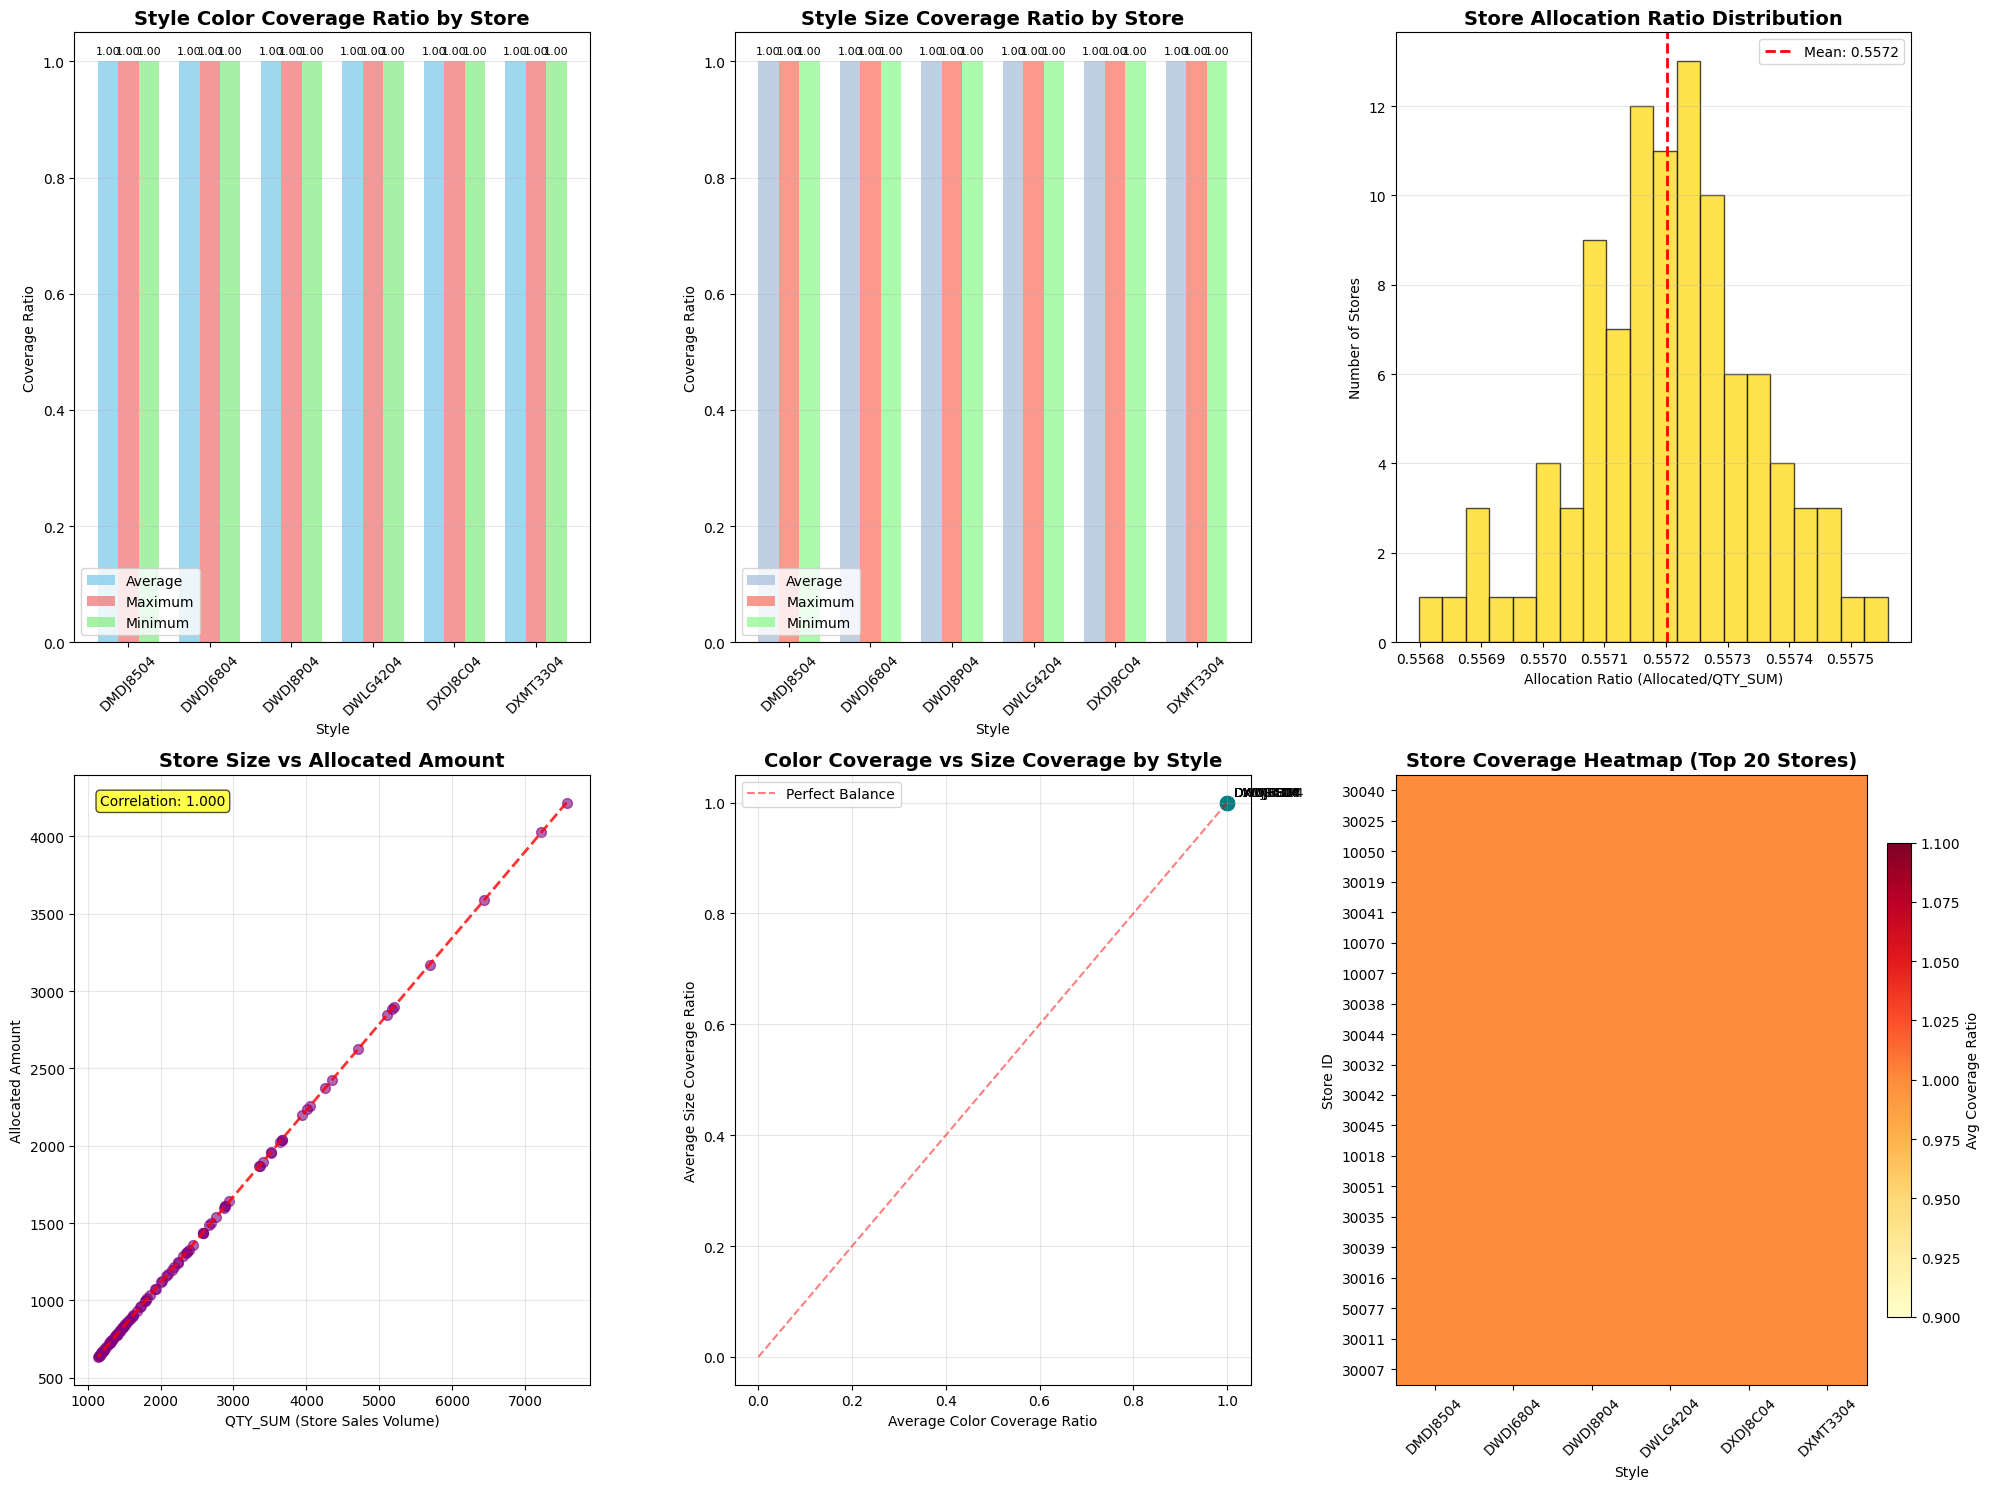

📈 시각화 완료!


In [46]:
# ===== 평가 메트릭 시각화 =====
print("\n🎯 평가 메트릭 시각화 시작...")

# 전체 그래프 설정
fig = plt.figure(figsize=(20, 15))

# ===== 1. 스타일별 컬러 커버리지 비율 막대 그래프 =====
plt.subplot(2, 3, 1)
style_names = list(style_color_coverage.keys())
color_avg_ratios = [style_color_coverage[s]['avg_ratio'] for s in style_names]
color_max_ratios = [style_color_coverage[s]['max_ratio'] for s in style_names]
color_min_ratios = [style_color_coverage[s]['min_ratio'] for s in style_names]

x_pos = range(len(style_names))
bars1 = plt.bar([x-0.25 for x in x_pos], color_avg_ratios, width=0.25, 
                label='Average', color='skyblue', alpha=0.8)
bars2 = plt.bar(x_pos, color_max_ratios, width=0.25, 
                label='Maximum', color='lightcoral', alpha=0.8)
bars3 = plt.bar([x+0.25 for x in x_pos], color_min_ratios, width=0.25, 
                label='Minimum', color='lightgreen', alpha=0.8)

plt.title('Style Color Coverage Ratio by Store', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Coverage Ratio')
plt.xticks(x_pos, [s[:8] for s in style_names], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 값 표시
for i, (avg, max_val, min_val) in enumerate(zip(color_avg_ratios, color_max_ratios, color_min_ratios)):
    plt.text(i-0.25, avg + 0.01, f'{avg:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, max_val + 0.01, f'{max_val:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i+0.25, min_val + 0.01, f'{min_val:.2f}', ha='center', va='bottom', fontsize=8)

# ===== 2. 스타일별 사이즈 커버리지 비율 막대 그래프 =====
plt.subplot(2, 3, 2)
size_avg_ratios = [style_size_coverage[s]['avg_ratio'] for s in style_names]
size_max_ratios = [style_size_coverage[s]['max_ratio'] for s in style_names]
size_min_ratios = [style_size_coverage[s]['min_ratio'] for s in style_names]

bars1 = plt.bar([x-0.25 for x in x_pos], size_avg_ratios, width=0.25, 
                label='Average', color='lightsteelblue', alpha=0.8)
bars2 = plt.bar(x_pos, size_max_ratios, width=0.25, 
                label='Maximum', color='salmon', alpha=0.8)
bars3 = plt.bar([x+0.25 for x in x_pos], size_min_ratios, width=0.25, 
                label='Minimum', color='palegreen', alpha=0.8)

plt.title('Style Size Coverage Ratio by Store', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Coverage Ratio')
plt.xticks(x_pos, [s[:8] for s in style_names], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 값 표시
for i, (avg, max_val, min_val) in enumerate(zip(size_avg_ratios, size_max_ratios, size_min_ratios)):
    plt.text(i-0.25, avg + 0.01, f'{avg:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, max_val + 0.01, f'{max_val:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i+0.25, min_val + 0.01, f'{min_val:.2f}', ha='center', va='bottom', fontsize=8)

# ===== 3. 매장별 분배 적정성 비율 히스토그램 =====
plt.subplot(2, 3, 3)
allocation_ratios = [data['ratio'] for data in store_allocation_ratio.values()]

plt.hist(allocation_ratios, bins=20, color='gold', alpha=0.7, edgecolor='black')
plt.title('Store Allocation Ratio Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Allocation Ratio (Allocated/QTY_SUM)')
plt.ylabel('Number of Stores')
plt.grid(axis='y', alpha=0.3)

# 통계값 표시
mean_ratio = sum(allocation_ratios) / len(allocation_ratios)
plt.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.4f}')
plt.legend()

# ===== 4. 매장 규모 vs 할당량 산점도 =====
plt.subplot(2, 3, 4)
qty_sums = [store_allocation_ratio[j]['qty_sum'] for j in stores]
allocated_amounts = [store_allocation_ratio[j]['allocated'] for j in stores]

plt.scatter(qty_sums, allocated_amounts, alpha=0.6, s=50, color='purple')
plt.title('Store Size vs Allocated Amount', fontsize=14, fontweight='bold')
plt.xlabel('QTY_SUM (Store Sales Volume)')
plt.ylabel('Allocated Amount')
plt.grid(True, alpha=0.3)

# 추세선 추가
import numpy as np
z = np.polyfit(qty_sums, allocated_amounts, 1)
p = np.poly1d(z)
plt.plot(qty_sums, p(qty_sums), "r--", alpha=0.8, linewidth=2)

# 상관계수 계산
correlation = np.corrcoef(qty_sums, allocated_amounts)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# ===== 5. 스타일별 평균 커버리지 비교 (컬러 vs 사이즈) =====
plt.subplot(2, 3, 5)
plt.scatter(color_avg_ratios, size_avg_ratios, s=100, alpha=0.7, color='teal')

for i, style in enumerate(style_names):
    plt.annotate(style[:8], (color_avg_ratios[i], size_avg_ratios[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('Color Coverage vs Size Coverage by Style', fontsize=14, fontweight='bold')
plt.xlabel('Average Color Coverage Ratio')
plt.ylabel('Average Size Coverage Ratio')
plt.grid(True, alpha=0.3)

# 대각선 추가 (이상적인 경우)
max_val = max(max(color_avg_ratios), max(size_avg_ratios))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Balance')
plt.legend()

# ===== 6. 매장별 커버리지 히트맵 (샘플) =====
plt.subplot(2, 3, 6)

# 상위 20개 매장의 스타일별 평균 커버리지 계산
top_stores = sorted(stores, key=lambda j: sum(int(x[i][j].value()) if x[i][j].value() else 0 for i in SKUs), reverse=True)[:20]

heatmap_data = []
for j in top_stores:
    row = []
    for s in styles:
        color_ratio = len(store_coverage[j][s]['colors']) / len(K_s[s]) if len(K_s[s]) > 0 else 0
        size_ratio = len(store_coverage[j][s]['sizes']) / len(L_s[s]) if len(L_s[s]) > 0 else 0
        avg_coverage = (color_ratio + size_ratio) / 2
        row.append(avg_coverage)
    heatmap_data.append(row)

im = plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
plt.title('Store Coverage Heatmap (Top 20 Stores)', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Store ID')
plt.xticks(range(len(styles)), [s[:8] for s in styles], rotation=45)
plt.yticks(range(len(top_stores)), [str(j) for j in top_stores])

# 컬러바 추가
plt.colorbar(im, fraction=0.046, pad=0.04, label='Avg Coverage Ratio')

plt.tight_layout()
plt.show()

print("📈 시각화 완료!")


In [47]:
# ===== 상세 분석 테이블 생성 =====
print("\n📋 상세 분석 테이블 생성 중...")

# ===== 1. 스타일별 종합 분석 테이블 =====
style_analysis = []
for s in styles:
    style_data = {
        'Style': s,
        'Total_Colors': len(K_s[s]),
        'Total_Sizes': len(L_s[s]),
        'Avg_Color_Coverage': style_color_coverage[s]['avg_ratio'],
        'Max_Color_Coverage': style_color_coverage[s]['max_ratio'],
        'Min_Color_Coverage': style_color_coverage[s]['min_ratio'],
        'Avg_Size_Coverage': style_size_coverage[s]['avg_ratio'],
        'Max_Size_Coverage': style_size_coverage[s]['max_ratio'],
        'Min_Size_Coverage': style_size_coverage[s]['min_ratio'],
        'Total_SKUs': len(I_s[s]),
        'Scarce_SKUs': len([i for i in I_s[s] if i in scarce]),
        'Abundant_SKUs': len([i for i in I_s[s] if i in abundant])
    }
    style_analysis.append(style_data)

df_style_analysis = pd.DataFrame(style_analysis)
print("\n🎨 스타일별 종합 분석:")
print(df_style_analysis.round(3))

# ===== 2. 매장 성과 분석 (상위/하위 10개 매장) =====
# 종합 성과 점수 계산 (커버리지 + 적정성)
store_performance = {}
for j in stores:
    # 전체 스타일에 대한 평균 커버리지 계산
    total_color_coverage = 0
    total_size_coverage = 0
    for s in styles:
        color_ratio = len(store_coverage[j][s]['colors']) / len(K_s[s]) if len(K_s[s]) > 0 else 0
        size_ratio = len(store_coverage[j][s]['sizes']) / len(L_s[s]) if len(L_s[s]) > 0 else 0
        total_color_coverage += color_ratio
        total_size_coverage += size_ratio
    
    avg_color_coverage = total_color_coverage / len(styles)
    avg_size_coverage = total_size_coverage / len(styles)
    allocation_ratio = store_allocation_ratio[j]['ratio']
    
    # 종합 점수 (커버리지 70% + 적정성 30%)
    performance_score = (avg_color_coverage + avg_size_coverage) * 0.35 + min(allocation_ratio, 1.0) * 0.3
    
    store_performance[j] = {
        'Store_ID': j,
        'Avg_Color_Coverage': avg_color_coverage,
        'Avg_Size_Coverage': avg_size_coverage,
        'Allocation_Ratio': allocation_ratio,
        'Performance_Score': performance_score,
        'Total_Allocated': store_allocation_ratio[j]['allocated'],
        'QTY_SUM': store_allocation_ratio[j]['qty_sum']
    }

# 상위 10개 매장
top_performers = sorted(store_performance.values(), key=lambda x: x['Performance_Score'], reverse=True)[:10]
df_top_performers = pd.DataFrame(top_performers)
print("\n🏆 상위 성과 매장 Top 10:")
print(df_top_performers.round(4))

# 하위 10개 매장
bottom_performers = sorted(store_performance.values(), key=lambda x: x['Performance_Score'])[:10]
df_bottom_performers = pd.DataFrame(bottom_performers)
print("\n⚠️  하위 성과 매장 Bottom 10:")
print(df_bottom_performers.round(4))

# ===== 3. 희소 SKU 배분 효과성 분석 =====
print("\n🔍 희소 SKU 배분 효과성 분석:")
scarce_effectiveness = {}

for i in scarce:
    # 해당 SKU의 스타일, 색상, 사이즈 추출
    sku_style = df_sku.loc[df_sku['SKU']==i, 'PART_CD'].iloc[0]
    sku_color = df_sku.loc[df_sku['SKU']==i, 'COLOR_CD'].iloc[0]
    sku_size = df_sku.loc[df_sku['SKU']==i, 'SIZE_CD'].iloc[0]
    
    # 할당된 매장 수
    allocated_stores = sum(1 for j in stores if b_hat.get((i,j), 0) == 1)
    
    # 해당 색상/사이즈를 커버하게 된 매장 수 계산
    color_coverage_contribution = 0
    size_coverage_contribution = 0
    
    for j in stores:
        if b_hat.get((i,j), 0) == 1:
            # 이 SKU로 인해 색상 커버리지가 생겼는지 확인
            other_same_color_skus = [sku for sku in store_coverage[j][sku_style]['allocated_skus'] 
                                   if sku != i and df_sku.loc[df_sku['SKU']==sku, 'COLOR_CD'].iloc[0] == sku_color]
            if not other_same_color_skus:
                color_coverage_contribution += 1
            
            # 이 SKU로 인해 사이즈 커버리지가 생겼는지 확인  
            other_same_size_skus = [sku for sku in store_coverage[j][sku_style]['allocated_skus'] 
                                  if sku != i and df_sku.loc[df_sku['SKU']==sku, 'SIZE_CD'].iloc[0] == sku_size]
            if not other_same_size_skus:
                size_coverage_contribution += 1
    
    scarce_effectiveness[i] = {
        'SKU': i,
        'Style': sku_style,
        'Color': sku_color,
        'Size': sku_size,
        'Supply_Qty': A[i],
        'Allocated_Stores': allocated_stores,
        'Coverage_Utilization': allocated_stores / A[i] if A[i] > 0 else 0,
        'Color_Coverage_Contribution': color_coverage_contribution,
        'Size_Coverage_Contribution': size_coverage_contribution,
        'Total_Coverage_Impact': color_coverage_contribution + size_coverage_contribution
    }

df_scarce_effectiveness = pd.DataFrame(list(scarce_effectiveness.values()))
print(df_scarce_effectiveness.round(3))

# ===== 4. 최종 종합 평가 =====
print("\n" + "="*60)
print("                  🎯 최종 종합 평가")
print("="*60)

# 전체 성과 메트릭 계산
overall_color_coverage = sum(style_color_coverage[s]['avg_ratio'] for s in styles) / len(styles)
overall_size_coverage = sum(style_size_coverage[s]['avg_ratio'] for s in styles) / len(styles)
overall_allocation_efficiency = sum(allocation_ratios) / len(allocation_ratios)
allocation_balance = 1 - (max(allocation_ratios) - min(allocation_ratios)) / max(allocation_ratios)  # 균형성

print(f"\n📊 전체 성과 요약:")
print(f"  🎨 평균 색상 커버리지: {overall_color_coverage:.3f} ({overall_color_coverage*100:.1f}%)")
print(f"  📏 평균 사이즈 커버리지: {overall_size_coverage:.3f} ({overall_size_coverage*100:.1f}%)")
print(f"  ⚖️  평균 분배 효율성: {overall_allocation_efficiency:.4f}")
print(f"  🎯 분배 균형성: {allocation_balance:.3f} ({allocation_balance*100:.1f}%)")

# 개선 권장사항
print(f"\n💡 개선 권장사항:")

# 낮은 커버리지 스타일 식별
low_coverage_styles = [(s, style_color_coverage[s]['avg_ratio'], style_size_coverage[s]['avg_ratio']) 
                       for s in styles 
                       if style_color_coverage[s]['avg_ratio'] < 0.5 or style_size_coverage[s]['avg_ratio'] < 0.5]

if low_coverage_styles:
    print("  📉 커버리지 개선 필요 스타일:")
    for style, color_cov, size_cov in low_coverage_styles:
        print(f"    - {style}: 색상 {color_cov:.2f}, 사이즈 {size_cov:.2f}")

# 분배 불균형 매장 식별
high_ratio_stores = [j for j in stores if store_allocation_ratio[j]['ratio'] > overall_allocation_efficiency * 2]
low_ratio_stores = [j for j in stores if store_allocation_ratio[j]['ratio'] < overall_allocation_efficiency * 0.5]

if high_ratio_stores:
    print(f"  📈 과도 분배 매장 ({len(high_ratio_stores)}개): {high_ratio_stores[:5]}{'...' if len(high_ratio_stores) > 5 else ''}")
if low_ratio_stores:
    print(f"  📉 과소 분배 매장 ({len(low_ratio_stores)}개): {low_ratio_stores[:5]}{'...' if len(low_ratio_stores) > 5 else ''}")

# 종합 등급 산정
total_score = (overall_color_coverage + overall_size_coverage + min(overall_allocation_efficiency, 1.0) + allocation_balance) / 4

if total_score >= 0.8:
    grade = "A (우수)"
elif total_score >= 0.7:
    grade = "B (양호)"
elif total_score >= 0.6:
    grade = "C (보통)"
elif total_score >= 0.5:
    grade = "D (개선필요)"
else:
    grade = "F (재검토필요)"

print(f"\n🏅 종합 평가 등급: {grade} (점수: {total_score:.3f})")

print("\n✅ 배분 결과 평가 완료!")

# 결과를 실험별 고유 경로로 CSV 저장
df_style_analysis.to_csv(experiment_file_paths['style_analysis'], index=False, encoding='utf-8-sig')
df_top_performers.to_csv(experiment_file_paths['top_performers'], index=False, encoding='utf-8-sig')
df_scarce_effectiveness.to_csv(experiment_file_paths['scarce_effectiveness'], index=False, encoding='utf-8-sig')

print(f"\n💾 분석 결과가 실험별 고유 CSV 파일로 저장되었습니다:")
print(f"  - 스타일 분석: {experiment_file_paths['style_analysis']}")
print(f"  - 상위 성과 매장: {experiment_file_paths['top_performers']}") 
print(f"  - 희소 SKU 효과성: {experiment_file_paths['scarce_effectiveness']}")

print(f"\n📁 실험 '{CURRENT_SCENARIO}' 결과가 모두 저장되었습니다:")
print(f"   🗂️  실험 폴더: {experiment_output_path}")
print(f"   📄 총 생성 파일: {len([f for f in experiment_file_paths.values() if os.path.exists(f)])}개")

# 실험 완료 시각화용 요약 정보
experiment_results_summary = {
    'scenario': CURRENT_SCENARIO,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'output_folder': experiment_output_path,
    'total_score': total_score,
    'grade': grade,
    'overall_color_coverage': overall_color_coverage,
    'overall_size_coverage': overall_size_coverage,
    'overall_allocation_efficiency': overall_allocation_efficiency,
    'allocation_balance': allocation_balance,
    'total_allocated_items': len(df_results) if 'df_results' in locals() and len(df_results) > 0 else 0,
    'file_paths': experiment_file_paths
}

print(f"\n🎯 실험 '{CURRENT_SCENARIO}' 최종 결과:")
print(f"   🏅 종합 등급: {grade} (점수: {total_score:.3f})")
print(f"   🎨 색상 커버리지: {overall_color_coverage:.3f}")
print(f"   📏 사이즈 커버리지: {overall_size_coverage:.3f}")
print(f"   ⚖️  분배 효율성: {overall_allocation_efficiency:.4f}")
print(f"   🎯 분배 균형성: {allocation_balance:.3f}")

# 전역 변수로 저장 (다른 실험과 비교용)
globals()[f'experiment_results_{CURRENT_SCENARIO}'] = experiment_results_summary



📋 상세 분석 테이블 생성 중...

🎨 스타일별 종합 분석:
       Style  Total_Colors  Total_Sizes  Avg_Color_Coverage  \
0  DMDJ85046             3            4                 1.0   
1  DWDJ68046             5            5                 1.0   
2  DWDJ8P046             5            4                 1.0   
3  DWLG42044             2            4                 1.0   
4  DXDJ8C046             9            6                 1.0   
5  DXMT33044             7            6                 1.0   

   Max_Color_Coverage  Min_Color_Coverage  Avg_Size_Coverage  \
0                 1.0                 1.0                1.0   
1                 1.0                 1.0                1.0   
2                 1.0                 1.0                1.0   
3                 1.0                 1.0                1.0   
4                 1.0                 1.0                1.0   
5                 1.0                 1.0                1.0   

   Max_Size_Coverage  Min_Size_Coverage  Total_SKUs  Scarce_SKUs  \
0    

In [48]:
# ===== 📊 실험 결과 비교 및 관리 도구 =====

def list_experiment_results():
    """저장된 모든 실험 결과 폴더 조회"""
    output_base = "../output"
    experiment_folders = []
    
    if os.path.exists(output_base):
        for folder in os.listdir(output_base):
            folder_path = os.path.join(output_base, folder)
            if os.path.isdir(folder_path) and '_' in folder:
                # 폴더명 패턴: scenario_timestamp
                parts = folder.split('_')
                if len(parts) >= 2:
                    try:
                        # 타임스탬프 파싱 가능한지 확인
                        timestamp = '_'.join(parts[-2:])  # YYYYMMDD_HHMMSS
                        scenario = '_'.join(parts[:-2])  # 시나리오명
                        
                        # 메타데이터 파일 확인
                        params_file = os.path.join(folder_path, f"{folder}_experiment_params.json")
                        if os.path.exists(params_file):
                            with open(params_file, 'r', encoding='utf-8') as f:
                                metadata = json.load(f)
                            
                            experiment_folders.append({
                                'folder_name': folder,
                                'scenario': scenario,
                                'timestamp': timestamp,
                                'datetime': metadata.get('timestamp', ''),
                                'status': metadata.get('optimization_status', 'unknown'),
                                'folder_path': folder_path,
                                'params_file': params_file
                            })
                    except:
                        continue
    
    # 시간순 정렬 (최신 순)
    experiment_folders.sort(key=lambda x: x['timestamp'], reverse=True)
    return experiment_folders

def compare_experiments(scenario_names=None, top_n=5):
    """실험 결과 비교 분석"""
    experiments = list_experiment_results()
    
    if scenario_names:
        # 특정 시나리오만 필터링
        experiments = [exp for exp in experiments if exp['scenario'] in scenario_names]
    
    if not experiments:
        print("비교할 실험 결과가 없습니다.")
        return None
    
    # 최신 top_n개만 선택
    experiments = experiments[:top_n]
    
    print(f"\n🔍 실험 결과 비교 분석 (총 {len(experiments)}개 실험)")
    print("="*80)
    
    comparison_data = []
    
    for exp in experiments:
        try:
            # 메타데이터 읽기
            with open(exp['params_file'], 'r', encoding='utf-8') as f:
                metadata = json.load(f)
            
            # 실험 결과 전역 변수에서 찾기 (실행된 경우)
            result_key = f"experiment_results_{exp['scenario']}"
            if result_key in globals():
                result_summary = globals()[result_key]
                total_score = result_summary.get('total_score', 0)
                grade = result_summary.get('grade', 'N/A')
                color_coverage = result_summary.get('overall_color_coverage', 0)
                size_coverage = result_summary.get('overall_size_coverage', 0)
                allocation_efficiency = result_summary.get('overall_allocation_efficiency', 0)
                balance = result_summary.get('allocation_balance', 0)
            else:
                # 메타데이터에서만 추출 가능한 정보
                total_score = 0
                grade = 'N/A'
                color_coverage = 0
                size_coverage = 0
                allocation_efficiency = 0
                balance = 0
            
            comparison_data.append({
                'Scenario': exp['scenario'],
                'Timestamp': exp['timestamp'],
                'Status': metadata.get('optimization_status', 'unknown'),
                'Objective_Value': metadata.get('objective_value', 0),
                'Total_Items': metadata.get('total_allocated_items', 0),
                'Total_Quantity': metadata.get('total_allocated_quantity', 0),
                'Coverage_Weight': metadata['parameters'].get('coverage_weight', 0),
                'Balance_Penalty': metadata['parameters'].get('balance_penalty', 0),
                'Allocation_Penalty': metadata['parameters'].get('allocation_penalty', 0),
                'Min_Allocation': metadata['parameters'].get('allocation_range_min', 0),
                'Max_Allocation': metadata['parameters'].get('allocation_range_max', 0),
                'Total_Score': total_score,
                'Grade': grade,
                'Color_Coverage': color_coverage,
                'Size_Coverage': size_coverage,
                'Allocation_Efficiency': allocation_efficiency,
                'Balance': balance,
                'Folder': exp['folder_name']
            })
            
        except Exception as e:
            print(f"⚠️  실험 {exp['folder_name']} 읽기 실패: {e}")
            continue
    
    if not comparison_data:
        print("비교 가능한 실험 데이터가 없습니다.")
        return None
    
    # DataFrame으로 변환 및 출력
    df_comparison = pd.DataFrame(comparison_data)
    
    print("\n📊 실험 파라미터 비교:")
    param_cols = ['Scenario', 'Status', 'Coverage_Weight', 'Balance_Penalty', 'Allocation_Penalty', 'Min_Allocation', 'Max_Allocation']
    print(df_comparison[param_cols].round(3))
    
    print("\n📈 성과 메트릭 비교:")
    performance_cols = ['Scenario', 'Total_Score', 'Grade', 'Color_Coverage', 'Size_Coverage', 'Allocation_Efficiency', 'Balance']
    print(df_comparison[performance_cols].round(4))
    
    print("\n📋 최적화 결과 비교:")
    result_cols = ['Scenario', 'Objective_Value', 'Total_Items', 'Total_Quantity']
    print(df_comparison[result_cols])
    
    # 최고 성과 실험 식별
    if df_comparison['Total_Score'].sum() > 0:
        best_experiment = df_comparison.loc[df_comparison['Total_Score'].idxmax()]
        print(f"\n🏆 최고 성과 실험:")
        print(f"   📌 시나리오: {best_experiment['Scenario']}")
        print(f"   🏅 점수: {best_experiment['Total_Score']:.4f} ({best_experiment['Grade']})")
        print(f"   📁 폴더: {best_experiment['Folder']}")
    
    return df_comparison

def cleanup_old_experiments(keep_latest=10):
    """오래된 실험 결과 정리 (최신 N개만 유지)"""
    experiments = list_experiment_results()
    
    if len(experiments) <= keep_latest:
        print(f"실험 결과가 {len(experiments)}개로 정리 기준({keep_latest}개) 이하입니다.")
        return
    
    # 오래된 실험들 선택
    to_delete = experiments[keep_latest:]
    
    print(f"\n🗑️  오래된 실험 {len(to_delete)}개를 정리합니다 (최신 {keep_latest}개 유지):")
    
    deleted_count = 0
    for exp in to_delete:
        try:
            import shutil
            shutil.rmtree(exp['folder_path'])
            print(f"   ❌ 삭제: {exp['folder_name']} ({exp['scenario']}, {exp['timestamp']})")
            deleted_count += 1
        except Exception as e:
            print(f"   ⚠️  삭제 실패: {exp['folder_name']} - {e}")
    
    print(f"\n✅ 정리 완료: {deleted_count}개 실험 폴더 삭제됨")

# 현재 사용 가능한 실험 관리 도구들
print("\n🛠️  실험 관리 도구들이 준비되었습니다:")
print("   📋 list_experiment_results(): 모든 실험 결과 조회")
print("   📊 compare_experiments(): 실험 결과 비교 분석")
print("   🗑️  cleanup_old_experiments(): 오래된 실험 정리")
print("\n💡 사용 예시:")
print("   experiments = list_experiment_results()")
print("   comparison = compare_experiments(['baseline', 'hybrid'], top_n=5)")
print("   cleanup_old_experiments(keep_latest=20)")



🛠️  실험 관리 도구들이 준비되었습니다:
   📋 list_experiment_results(): 모든 실험 결과 조회
   📊 compare_experiments(): 실험 결과 비교 분석
   🗑️  cleanup_old_experiments(): 오래된 실험 정리

💡 사용 예시:
   experiments = list_experiment_results()
   comparison = compare_experiments(['baseline', 'hybrid'], top_n=5)
   cleanup_old_experiments(keep_latest=20)
